# Cardio Tocograph (CTG) Data and Fetal Health Predictions
Using Standard CTG results to more rapidly detect
latent health concerns during pregnancy.

Data used herein was obtained from
[here, via kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)  
<sup>kaggle data set was obtained via this research - 
[Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)</sup>

## Overview
Cardiotocographs, or CTGs, measure vital data related
to fetal health. They are usually performed in the
third trimester - or slightly earlier in cases where
other health issues may be of concern during the
pregnancy. Often, there is a lot that goes into reading
the results of a CTG, and while it is always important
to have a trained professional review results, it can
be helpful and reassuring to have an idea of what the
results may look like.

For an informal look at what reading the results
entails,
[here](https://geekymedics.com/how-to-read-a-ctg/)
is a brief article from
[geekymedics.com](https://geekymedics.com/)
discussing what the parts of a reading are.

This model and reasearch aims to make this process
slightly more simple and accessible to doctors and
expecting parents.

### The Data
The
[Kaggle dataset mentioned earlier](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)
was gathered as part of a research project in 2000
aimed at automating the analysis of these results. It
includes 2,126 entries with 21 features and 1 target
value. For a more direct explanation of the data, the
information is available in both the paper and the
dataset or
[here](./data/fetal_health_descriptions.md)
in the form of column descriptions.

### Metrics Used
For this project, the primary metric investigated is
the recall score of the model. This is because it is
entirely acceptable to raise a flag of concern that is
unnecessary as opposed to it being near-unacceptable to
miss a point of concern. Taking an extra look at a
healthy fetus can cost some time and money, but not
looking at a fetus that has health concerns can cost a
life, or even more.

## Exploration, Analysis, and the First Model
This project will start off with importing the data set
and ensuring that the data is clean and usable.

If you wish to recreate this process, a Python Conda
environment is available in the repository under data.

### Imports and Cleaning

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import Markdown

from sklearn.model_selection import train_test_split, GridSearchCV, \
                            cross_val_score
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix, \
                            recall_score, accuracy_score, \
                                precision_score, \
                            roc_curve, roc_auc_score, \
                            auc, \
                            RocCurveDisplay, ConfusionMatrixDisplay, \
                            classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from code.model_verification import model_scoring, \
                        model_scoring_table

%matplotlib inline

In [2]:
# setting default plotting items
sns.set()
sns.set(font_scale=2)

Here we import the aforementioned data set and show
what we can expect.

In [3]:
fetal_df = pd.read_csv('./data/fetal_health.csv')
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
print(fetal_df.info(), \
    f"""\n\n
    Data shape: {fetal_df.shape}
    Total nulls in data set: {fetal_df.isna().sum().sum()}
    """)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

Fortunately, it looks like there are no null values.
All of the data in this dataset are stored as floats as
well, but a couple of the columns have names that might
indicate that they are categorical.

Let's go ahead and get the column names into formatted
titles for use later.

In [5]:
clean_titles = [column.replace('_',' ').title() for column in fetal_df.columns]

In [6]:
health_labels = ['Normal','Suspect','Pathological']

In [7]:
# display the columns that seem like they could be made
# into categorical variables, possibly at least 

print(f"""
{fetal_df.value_counts('fetal_health')}

{fetal_df.value_counts('histogram_number_of_peaks')}

{fetal_df.value_counts('histogram_number_of_zeroes')}
""")


fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64

histogram_number_of_peaks
1.0     357
2.0     331
3.0     269
4.0     258
5.0     210
6.0     158
7.0     145
0.0     107
8.0     106
9.0      67
10.0     49
11.0     28
12.0     22
13.0     10
14.0      5
16.0      2
15.0      1
18.0      1
dtype: int64

histogram_number_of_zeroes
0.0     1624
1.0      366
2.0      108
3.0       21
5.0        2
4.0        2
10.0       1
8.0        1
7.0        1
dtype: int64



It looks like the only metric that can effectively
be broken out into categories is the target, fetal
health. For now, we'll go ahead and keep it all as-is
and see how that feature is broken down.

### Checking the values

In [8]:
print(fetal_df.value_counts('fetal_health') , '\n\n' , fetal_df.value_counts('fetal_health', normalize=True))

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64 

 fetal_health
1.0    0.778457
2.0    0.138758
3.0    0.082785
dtype: float64


From the [description of values in the dataset](./data/fetal_health_descriptions.md),
the values are heavily imbalanced in favor of "Normal" health.
1. Normal
2. Suspect
3. Pathological

## Determining the measure

Because the health of a child and mother are important,
the measure that this project will be employing will be
recall. It is imperative that as many suspect or
pathological cases are found as possible. An accidental
flag or false positive is more acceptable than missing
the cases where an issue is present.

This project will focus on maximizing the recall score
in an attempt to most accurately predict cases where a
pregnancy is showing potential signs of issues.

## Additional Data Preparation
### Defining X and y, creating splits

We'll split our target and feature columns so that we
can create our models.

Here we subtract 1 from all of our y values so that our
false values are equal to 0, this just makes our data
easier to look at later.

In [9]:
X = fetal_df.drop(columns=['fetal_health'])
y = fetal_df['fetal_health']-1

In [10]:
# we will stratify on the y values here to ensure that
# the proportion of the test and train data remains
# mostly the same, this is mostly to make sure that our
# test data actually has some of the values we are 
# targeting 
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, random_state=1,
                    test_size=0.2, stratify=y
)

## Creating and Validating the Dummy Model

In [11]:
dummy_baseline = DummyClassifier(strategy='most_frequent')
dummy_baseline.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [12]:
y_train_preds = dummy_baseline.predict(X_train)
y_train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
y_train

1391    0.0
926     0.0
111     0.0
1207    0.0
897     0.0
       ... 
2027    2.0
441     0.0
1449    0.0
1512    0.0
789     0.0
Name: fetal_health, Length: 1700, dtype: float64

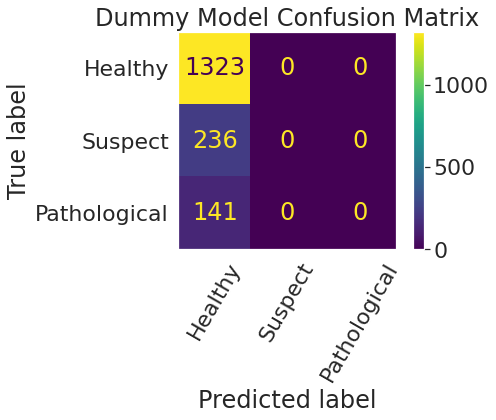

In [14]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(dummy_baseline,X_train,y_train,
    ax=ax
    #labels={1:'Healthy',2:'Suspect',3:'Pathological'}
    );

ax.set(
    yticklabels=['Healthy','Suspect','Pathological'],
    xticklabels=['Healthy','Suspect','Pathological'],
    title="Dummy Model Confusion Matrix"
);
plt.xticks(rotation=60)
ax.grid(False)

In [15]:
model_scoring(dummy_baseline.fit(X_train,y_train),X_train,y_train,
            average='macro',
            plot_curve=False,
            multi_class='ovr');


Model recall:       0.0
Mean ROC AUC score: 0.5
Cross Val Score:    0.0
    


Visually, we can see that the 2 labels we care about are
entirely incorrectly predicted. We'll want to over-sample
our target values to improve our predictions on them.
From this dummy model, there's nowhere to go but up. A
prediction across the board of 0% recall is all but
useless.

We'll go ahead and start creating our initial models from
here.

# Initial Models

Throughout this process, we will mostly be using SMOTE
to perform our over-sampling. We'll perform this
process within a pipeline and will modify methods and
parameters throughout using several grid searching
options, keeping our initial models in mind to verify
improvement. Additionally, since all of our features
are floats, we'll perform scaling on them in the same
way.

## Approach 1: KNN

Our first approach will be to try a K Nearest Neighbors
method to see if we're able to correctly predict our
outcomes with a distance-based method.

We'll stick with our ideology mentioned at the end of
the last section.

In [16]:
# creating our initial pipeline
initial_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])
initial_knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('knn', KNeighborsClassifier(n_jobs=-2))])

Let's go ahead and get a confusion matrix like we did
for the dummy model earlier

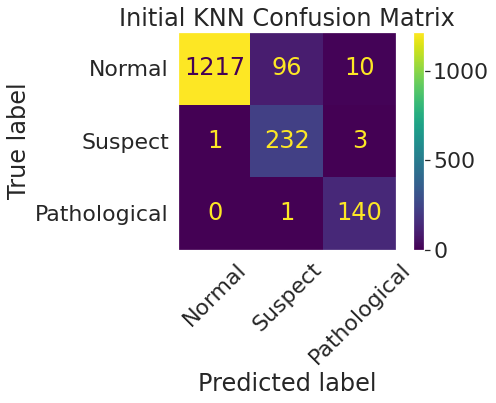

In [17]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(
                    initial_knn_pipeline,
                    X_train,y_train,
                    ax=ax);
ax.set(
    yticklabels=health_labels,
    xticklabels=health_labels,
    title="Initial KNN Confusion Matrix"
);
ax.grid(False)

plt.xticks(rotation=45)

'';

We actually see some really good results immediately,
but we want to make sure that our cross-val score is
also representative of this.


Model recall:       0.9879793244380335
Mean ROC AUC score: 0.9980725145473125
Cross Val Score:    0.8501569978688467
    


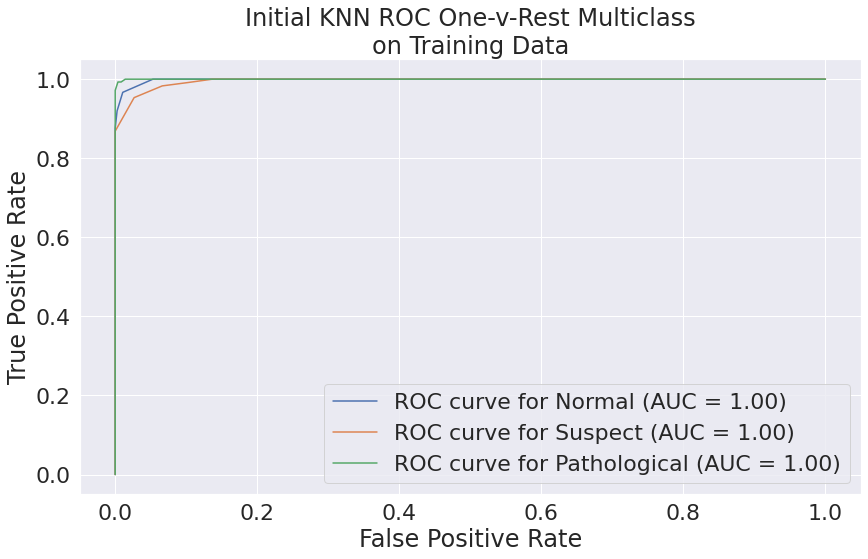

In [18]:
fig, ax = plt.subplots(figsize=(14,8))
scores_knn_initial = model_scoring(initial_knn_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial KNN " + ax.title.get_text() + "\non Training Data"
)

'';

This model is showing 100% in all categories for its
ROC AUC predictions, which is... suspicious. It's very likely
that the model is extremely overfit - we'll go ahead
and run a grid search on this to see what all we can
do to tweak this model.

We can see that the model is also extremely over fit,
the recall score sits _*13%*_ over the cross val score.
This will need to be looked into.

### Performing the First Grid Search:
We'll step through several parameters automatically
using a grid search. This is a process that will be
performed several times throughout this notebook in an
attempt at finding the best parameters and the best
model from a list of options. Initially, we'll use our
KNN parameters with the default options as the middle
values and look at how parameters on either side
perform.

In [19]:
# default knn params here are 5 n_neighbors and a p of
# 2. We'll set our SMOTE sampling strategy to try auto
# and all. We can't run this on floats since the target
# is multi-class. 
knn_params = {
    'o__sampling_strategy':['auto','all'],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[1,2,3]
}

In [20]:
knn_gs = GridSearchCV(
    initial_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [21]:
knn_gs.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [22]:
knn_gs.best_params_ , knn_gs.best_estimator_

({'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3, p=1))]))

And here we'll check how this model is scoring across a
few default scoring metrics.


Model recall:       0.9922166125736267
Mean ROC AUC score: 0.9993629010696551
Cross Val Score:    0.8232601404464941
    


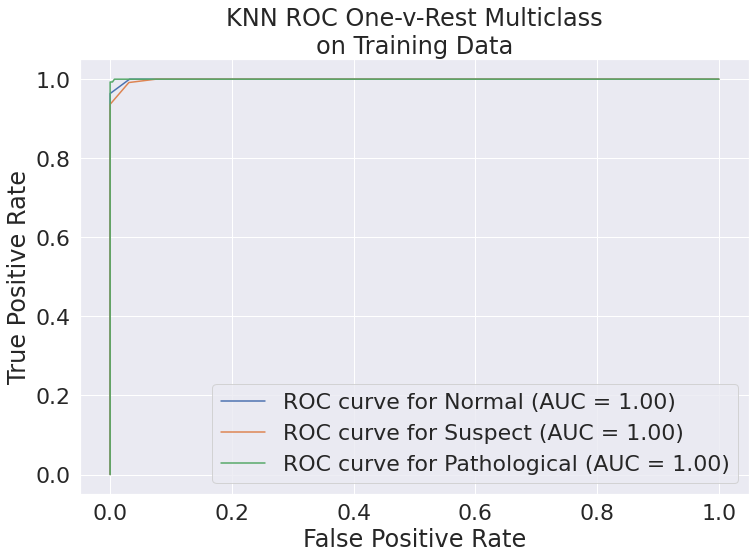

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

# model_scoring is available in the code.py file in the
# ./code folder of this repository, along with a table
# function that will be used later 

scores_best_knn_initial = model_scoring(
    knn_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="KNN " + ax.title.get_text() + "\non Training Data"
)

'';


This model is still showing an AUC of 1 on _**ALL**_
targets. Additionally, the cross val score is much 
lower. We are still likely over-fitting pretty
heavily. We'll want to take a look at the data a
little closer and see what data is impacting this the
most and try to simplify the model to use less features
as this should improve  generalization.

An additional way that we can see some over-fit being
indicated is that our cross val score actually went
down when performing this test, so the grid search is
prioritizing our training data set as much as it can.

### Showing that the features are not generalizing well:

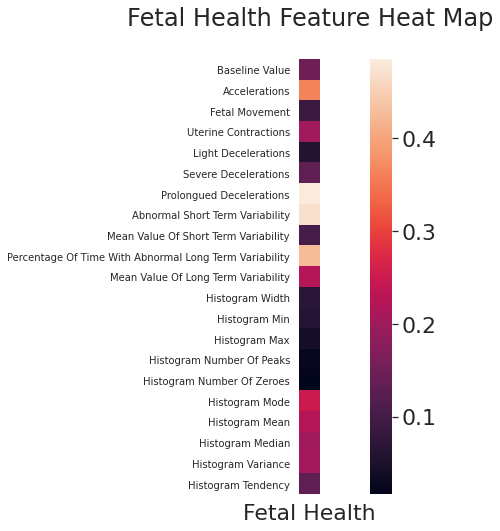

In [24]:
fig, ax = plt.subplots(figsize=(18,8))

sns.heatmap(np.abs(fetal_df.corr())[:-1][['fetal_health']],square=True,ax=ax,
yticklabels=True)

ax.yaxis.set_minor_locator(MaxNLocator(integer=True,nbins=len(clean_titles)-1))
ax.set_yticklabels(
    clean_titles[:-1],fontsize=10)
ax.set(
    title="Fetal Health Feature Heat Map\n",
    xticklabels=['Fetal Health']
)

'';

Here, we can see that there are a handful of features
that are effecting the target values more than others.

Here, we'll extract the 5 features of highest
importance according to our heat map and .corr()
values.

In [25]:
# sort_values defaults to lowest-to-highest, will use
# .tail instead of ascending=False 
highest_effect = list((abs_corr_eff := np.abs(fetal_df.corr()[:-1]['fetal_health']).sort_values()).tail().index)
highest_effect, abs_corr_eff

(['histogram_mode',
  'accelerations',
  'percentage_of_time_with_abnormal_long_term_variability',
  'abnormal_short_term_variability',
  'prolongued_decelerations'],
 histogram_number_of_zeroes                                0.016682
 histogram_number_of_peaks                                 0.023666
 histogram_max                                             0.045265
 light_decelerations                                       0.058870
 histogram_min                                             0.063175
 histogram_width                                           0.068789
 fetal_movement                                            0.088010
 mean_value_of_short_term_variability                      0.103382
 severe_decelerations                                      0.131934
 histogram_tendency                                        0.131976
 baseline value                                            0.148151
 uterine_contractions                                      0.204894
 histogram_median

After extracting the 5 values with the highest 
influence on the data, we'll create a new model that
only takes these features into account when training.  
We'll create an X_test variable for use later as well.

In [26]:
X_train_top_features = X_train[highest_effect]
X_test_top_features  = X_test[highest_effect]

# verifying the shape
X_train_top_features.head()

,histogram_mode,accelerations,percentage_of_time_with_abnormal_long_term_variability,abnormal_short_term_variability,prolongued_decelerations
1391,148.0,0.000,9.0,58.0,0.0
926,126.0,0.000,4.0,27.0,0.0
111,137.0,0.005,0.0,34.0,0.0
1207,144.0,0.006,2.0,45.0,0.0
897,150.0,0.000,0.0,32.0,0.0


...and we'll create the relative pipelines for the same
data

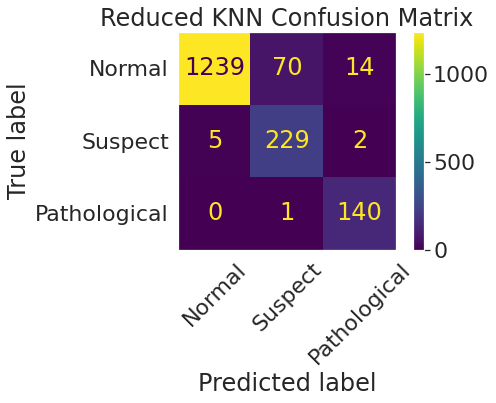

In [27]:
reduced_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

reduced_knn_pipeline.fit(X_train_top_features,y_train)

fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(
            reduced_knn_pipeline,X_train_top_features,y_train,
            ax=ax);

ax.set(
    title="Reduced KNN Confusion Matrix",
    yticklabels=health_labels,
    xticklabels=health_labels
)
ax.grid(False)

plt.xticks(rotation=45)

'';


Model recall:       0.9816233922346436
Mean ROC AUC score: 0.9974224386560683
Cross Val Score:    0.8698315166125143
    


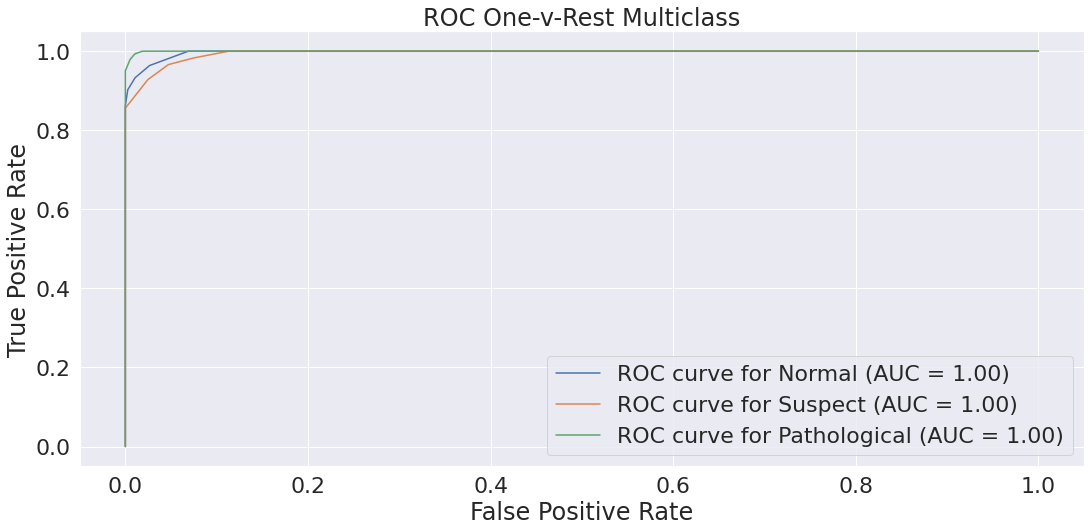

In [28]:
fig, ax = plt.subplots(figsize=(18,8))

scores_reduced_knn_initial = model_scoring(
    reduced_knn_pipeline,X_train_top_features,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels
    
)

In [29]:
scores_reduced_knn_initial

{'recall': 0.9816233922346436,
 'rocauc': 0.9974224386560683,
 'cv_score': array([0.87917933, 0.8468845 , 0.87196049, 0.8672047 , 0.88392857]),
 'ax': <AxesSubplot:title={'center':'ROC One-v-Rest Multiclass'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>}

This model actually has a 2% increase in CV score so we
should mark it as our best model so far. 2% is a small
increase for most cases, but when it comes to health
and safety, every percent is important.

We'll use the same options as before to generate the
grid search, so we don't have to define new params. If
we detect the model picking edges, we can investigate
those params further.

In [30]:

knn_reduced_gs = GridSearchCV(
    reduced_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [31]:
knn_reduced_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [32]:
knn_reduced_gs.best_params_, knn_reduced_gs.best_estimator_

({'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3, p=1))]))


Model recall:       0.9837420363024402
Mean ROC AUC score: 0.9989318598805665
Cross Val Score:    0.8604793348006847
    


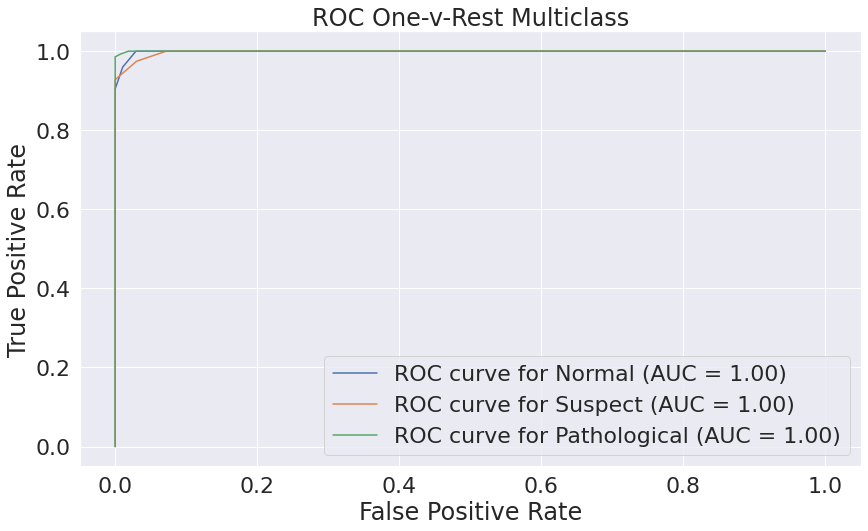

In [33]:
fig, ax = plt.subplots(figsize=(14,8))

scores_best_knn_reduced = model_scoring(
    knn_reduced_gs.best_estimator_,
    X_train_top_features,y_train,average='macro',
    plot_curve=True,ax=ax,class_names=health_labels
)

The grid search actually takes the model down just a
bit, so we'll keep the prior model based on CV score.

## Investigating the Models

Now that we have a few models, we should put all of
their results into one place to really best understand
what exactly is happening with all of the scores. This
is a step that will be taken each time we complete a
few steps in changing the models to see our progress.

In [34]:
display(model_scoring_table(
    [
        scores_knn_initial,
        scores_best_knn_initial,
        scores_reduced_knn_initial,
        scores_best_knn_reduced
    ],[
        'KNN Initial',
        'Grid Searched KNN',
        'KNN Initial Reduced',
        'Grid Searched KNN Reduced'
    ]
)['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| KNN Initial |  0.988  |  0.998  |  0.850  |
| Grid Searched KNN | **0.992** | **0.999** |  0.823  |
| KNN Initial Reduced |  0.982  |  0.997  | ***0.870*** |
| Grid Searched KNN Reduced |  0.984  | **0.999** |  0.860  |


In [35]:
knn_reduced_gs.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'}

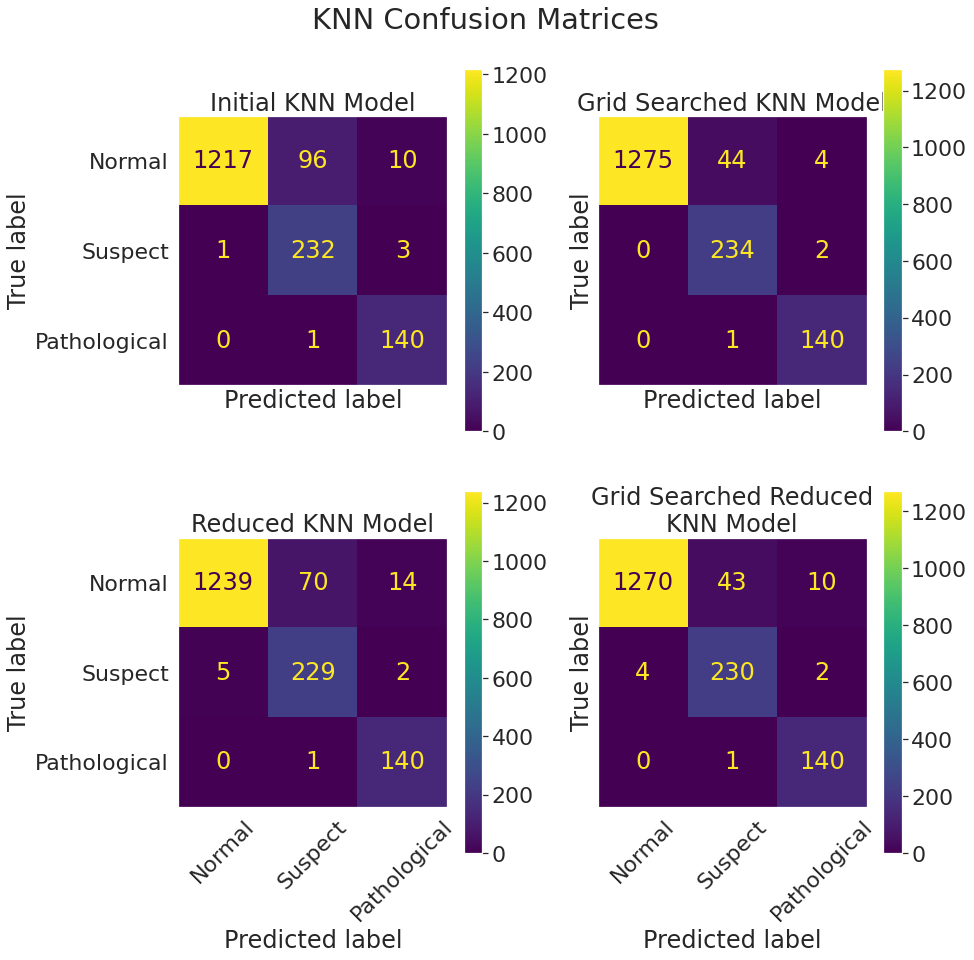

In [36]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharey=True,sharex=True)

ConfusionMatrixDisplay.from_estimator(
            initial_knn_pipeline.fit(X_train,y_train),X_train,y_train,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            knn_gs,X_train,y_train,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            reduced_knn_pipeline.fit(X_train_top_features,y_train),X_train_top_features,y_train,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            knn_reduced_gs,X_train_top_features,y_train,ax=ax[1,1])

ax[0,0].set(
    title='Initial KNN Model'
)
ax[0,1].set(
    title='Grid Searched KNN Model'
)
ax[1,0].set(
    title='Reduced KNN Model'
)
ax[1,1].set(
    title='Grid Searched Reduced\nKNN Model'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

These models are starting to take shape and look pretty
decent, but we want to make them as good of models as
we can. We'll take a look now at adding some features
to the grid search that was done above since the best
params include our lowest number of neighbors. We'll
look at the option of weighting based on distance in
lieu of keeping our neighbors so low. We'll keep all
of our other options the same for the meantime and we
can perform the grid search through the same process.

In [37]:
knn_params_weighted = knn_params
knn_params_weighted['knn__weights'] = ['uniform','distance']

knn_reduced_gs_weighted = GridSearchCV(
    reduced_knn_pipeline,
    param_grid=knn_params_weighted,
    n_jobs=-2,verbose=3
)

In [38]:
knn_reduced_gs_weighted.fit(X_train_top_features,y_train)
knn_reduced_gs_weighted.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'knn__n_neighbors': 3,
 'knn__p': 1,
 'knn__weights': 'distance',
 'o__sampling_strategy': 'auto'}


Model recall:       0.9936440677966102
Mean ROC AUC score: 0.9999926511240845
Cross Val Score:    0.8562240156517487
    


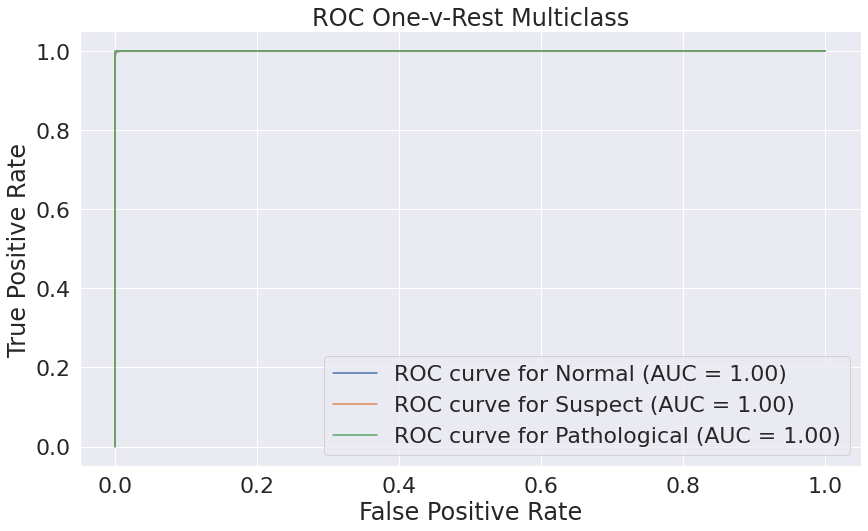

In [39]:
scores_reduced_knn_gs_weighted = model_scoring(knn_reduced_gs_weighted.best_estimator_,
                X_train_top_features,y_train,
                average='macro',plot_curve=True,
                class_names=health_labels);

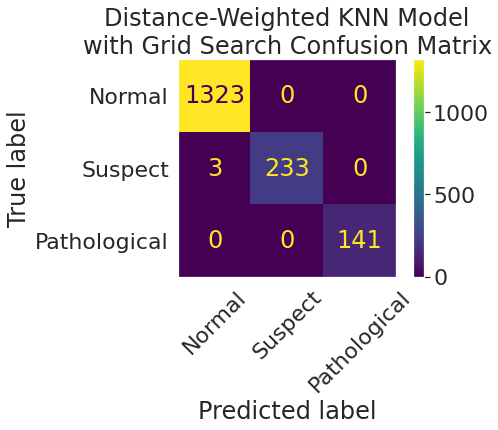

In [40]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(knn_reduced_gs_weighted,
                        X_train_top_features,y_train,ax=ax)

ax.set(
    title="Distance-Weighted KNN Model\nwith Grid Search Confusion Matrix",
    xticklabels=health_labels,
    yticklabels=health_labels
)
ax.grid(False)
plt.xticks(rotation=45)
'';

In [41]:
display(model_scoring_table(
    [
        scores_reduced_knn_initial,
        scores_reduced_knn_gs_weighted
    ],[
        'Initial KNN Reduced',
        'Distance-Weighted KNN Reduced'
        
    ]
)['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Initial KNN Reduced |  0.982  |  0.997  | ***0.870*** |
| Distance-Weighted KNN Reduced | **0.994** | **1.000** |  0.856  |


The CV score for the previous model is still better
than the score for this model. It looks like this model
really only increased the overfit. We'll move on to the
next approach from here and keep the best model from
this section as a note for comparison.

## Approach 2: Random Forest

### Creating the Initial Model
This is mostly the same process as before, only we use
a random forest classifier here, which is really just a
more complex version of a decision tree classifier. We
skip straight to the Random Forest over the Decision
Tree because, in general, there is only benefit to
using a random forest. It effectively runs multiple
decision trees and uses the best of those. Since the
data set isn't in the tens or hundreds of thousands, we
shouldn't see much issue in terms of performance here
over a regular decision tree.

In [42]:
initial_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
initial_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

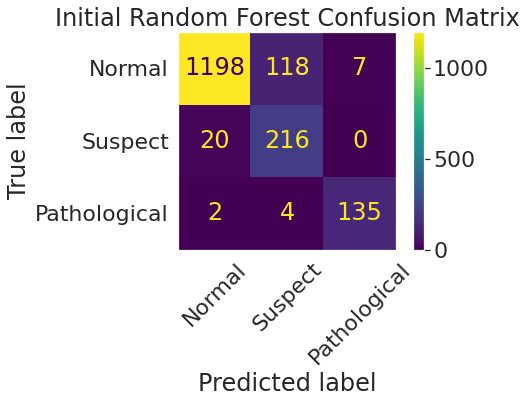

In [43]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(initial_tree_pipeline,X_train,y_train,
                        ax=ax);
ax.set(
    title="Initial Random Forest Confusion Matrix",
    xticklabels=health_labels,
    yticklabels=health_labels
)
ax.grid(False)
plt.xticks(rotation=45)
'';


Model recall:       0.9363505228993869
Mean ROC AUC score: 0.9849576125520768
Cross Val Score:    0.8556759424239248
    


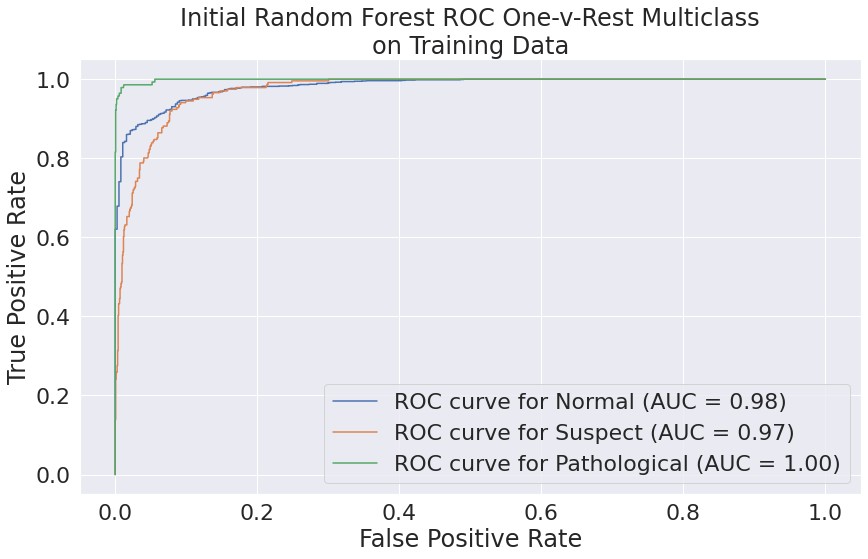

In [44]:
fig, ax = plt.subplots(figsize=(14,8))
scores_tree_initial = model_scoring(initial_tree_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial Random Forest " + ax.title.get_text() + "\non Training Data"
)

'';

Our recall score does go down here, but our cv score is
pretty similar, being down by about 1%. This means that
this model isn't over fitting as badly to our training
data, but it is still generalizing a bit worse, even if
it's not by much.

Still, these results would indicate that this is very
much a model worth investigating.

We'll run a grid search just like before.

In [45]:
tree_params = {
    'o__sampling_strategy':['auto','all'],
    'rfc__max_depth': [3,5,7],
    'rfc__min_samples_split': [2,4,6]
}

In [46]:
tree_gs = GridSearchCV(
    initial_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3
)

In [47]:
tree_gs.fit(X_train,y_train)
tree_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'o__sampling_strategy': 'auto',
 'rfc__max_depth': 7,
 'rfc__min_samples_split': 4}


Model recall:       0.9667478062267099
Mean ROC AUC score: 0.9934588937750992
Cross Val Score:    0.8919094783915034
    


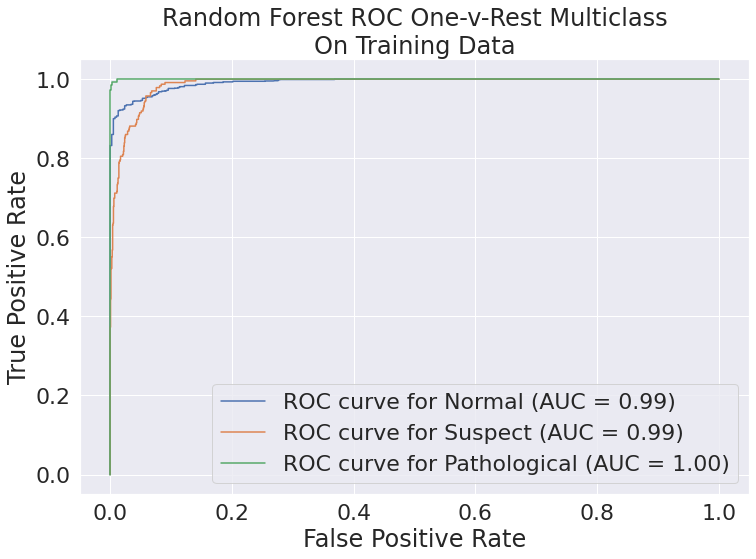

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
scores_best_tree_initial = model_scoring(
    tree_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Random Forest " + ax.title.get_text() + "\nOn Training Data"
);

Our CV score went up a pretty decent amount here and
even reduced over fit by a bit at the same time! Our
new best model is probably going to have to be this
random forest with an 89.2% cv score.

Just like before, we should have the tree take a look
at a smaller set of parameters. First, we'll have the
tree look at the same subset that our KNN model did to
get a good comparison between the classifications of
both.

In [49]:
reduced_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
reduced_tree_pipeline.fit(X_train_top_features,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])


Model recall:       0.9349230676764034
Mean ROC AUC score: 0.9808657978120546
Cross Val Score:    0.8947181899171994
    


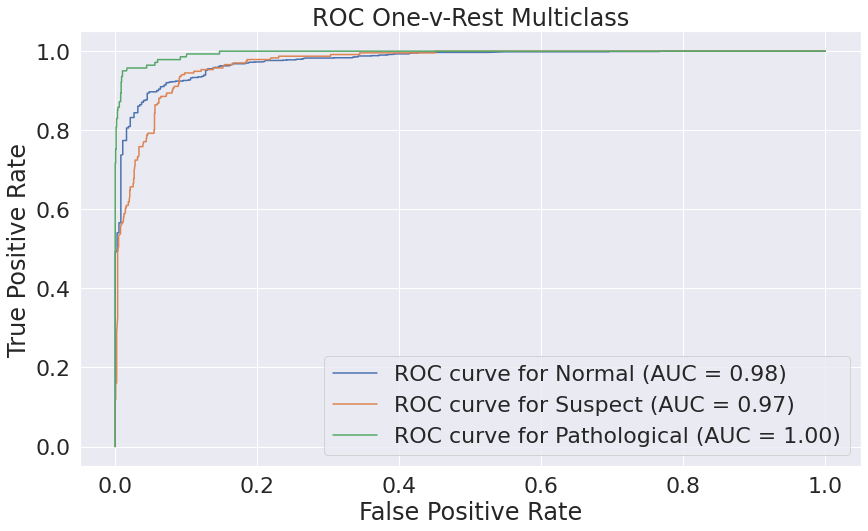

In [50]:
fig,ax = plt.subplots(figsize=(14,8))
scores_reduced_tree_initial = model_scoring(
    reduced_tree_pipeline,
    X_train_top_features,y_train,
    average='macro',plot_curve=True,ax=ax,
    class_names=health_labels
)

Our cross val score went up by a little bit, measuring
in the tenths of percentage points, but it's still
worth noting.

Let's go ahead and take another grid search using the
same parameters as before.

In [51]:
reduced_tree_gs = GridSearchCV(
    reduced_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3)
reduced_tree_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=5,
                                                               n_jobs=-2,
                                                               random_state=1))]),
             n_jobs=-2,
             param_grid={'o__sampling_strategy': ['auto', 'all'],
                         'rfc__max_depth': [3, 5, 7],
                         'rfc__min_samples_split': [2, 4, 6]},
             verbose=3)


Model recall:       0.9596556076451497
Mean ROC AUC score: 0.9902798704926536
Cross Val Score:    0.8990966617754953
    


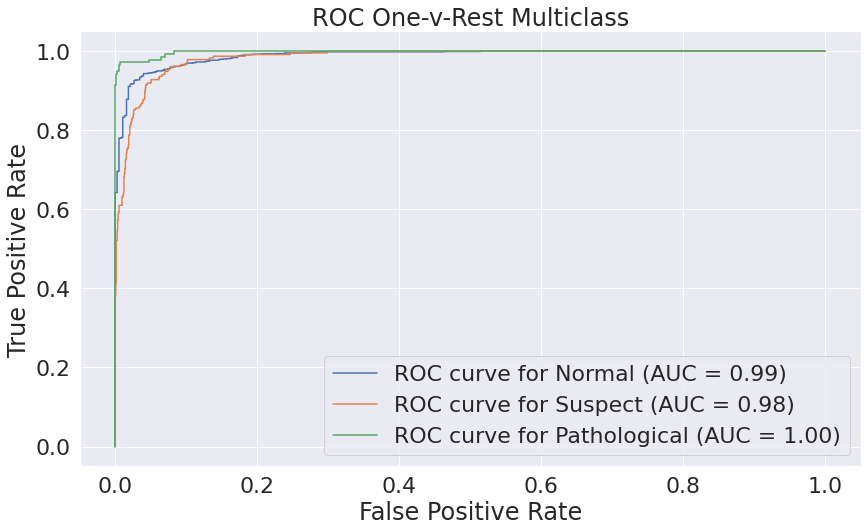

In [52]:
fig, ax = plt.subplots(figsize=(14,8))
scores_best_tree_reduced = model_scoring(
    reduced_tree_gs.best_estimator_,
    X_train_top_features,y_train,
    average='macro',
    plot_curve=True,
    ax=ax, class_names=health_labels
)

And again, we'll compare the models.

In [53]:
display_table = model_scoring_table([
    scores_tree_initial,
    scores_best_tree_initial,
    scores_reduced_tree_initial,
    scores_best_tree_reduced
],[
    'Forest Initial',
    'Grid Searched Initial Forest',
    'Forest Initial Reduced',
    'Grid Searched Forest Reduced'
    ])
display(display_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Forest Initial |  0.936  |  0.985  |  0.856  |
| Grid Searched Initial Forest | **0.967** | **0.993** |  0.892  |
| Forest Initial Reduced |  0.935  |  0.981  |  0.895  |
| Grid Searched Forest Reduced |  0.960  |  0.990  | ***0.899*** |


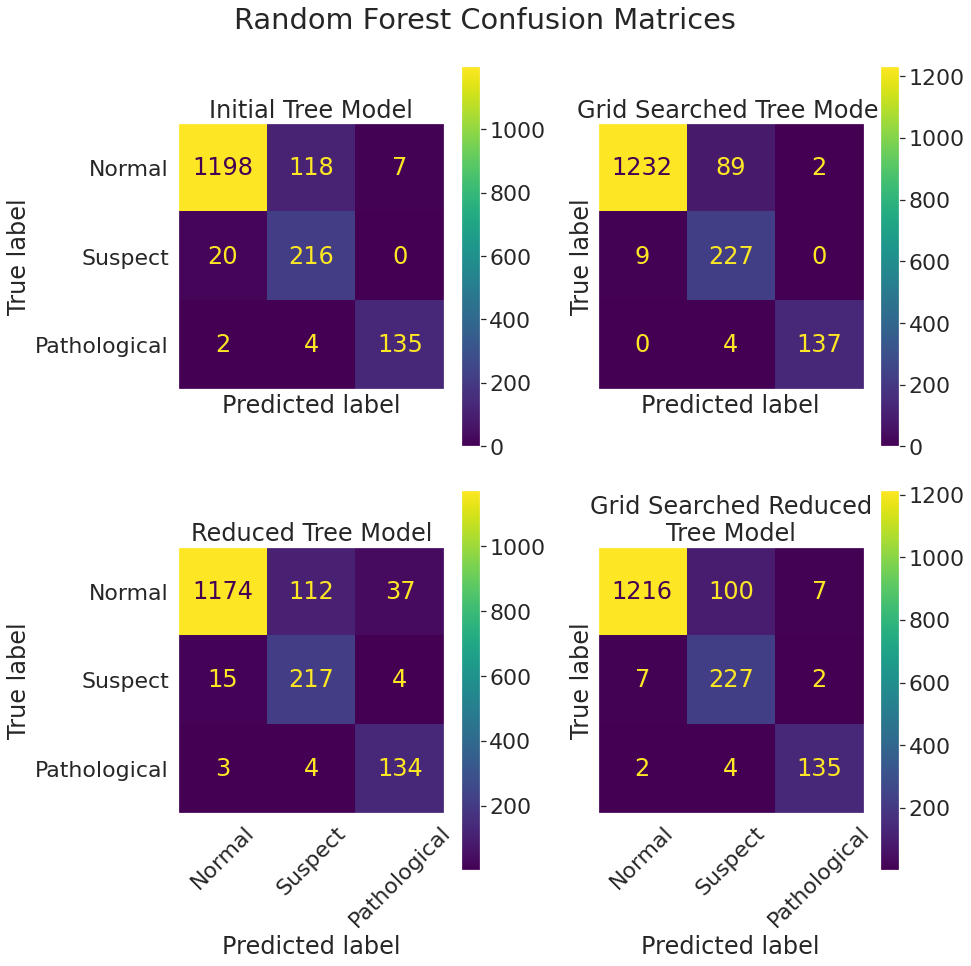

In [54]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharex=True,sharey=True)

ConfusionMatrixDisplay.from_estimator(
            initial_tree_pipeline.fit(X_train,y_train),X_train,y_train,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            tree_gs,X_train,y_train,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            reduced_tree_pipeline.fit(X_train_top_features,y_train),X_train_top_features,y_train,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            reduced_tree_gs,X_train_top_features,y_train,ax=ax[1,1])

ax[0,0].set(
    title='Initial Tree Model'
)
ax[0,1].set(
    title='Grid Searched Tree Model'
)
ax[1,0].set(
    title='Reduced Tree Model'
)
ax[1,1].set(
    title='Grid Searched Reduced\nTree Model'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

fig.suptitle("Random Forest Confusion Matrices")

plt.tight_layout()

It looks like we had slight improvements at every step.
Any of these models could be just as good as one
another depending on the data sets, but we'll go with
the model that has the best score outright, as that's
generally the best model, even if the scores are only
different by tenths of percents. 89.9% is better than
89.2% in every way. It also helps that it is the least
over-fit of the models in this section.

Let's go ahead and put the two best models together and
see how they compare.

In [55]:
score_table = model_scoring_table([
    scores_best_knn_reduced,
    scores_best_tree_reduced
    ],[
    'Grid Searched KNN Reduced',
    'Grid Searched Reduced Forest'
])
display(score_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | **0.984** | **0.999** |  0.860  |
| Grid Searched Reduced Forest |  0.960  |  0.990  | ***0.899*** |


Among our existing models, our reduced tree is up by
about 4% over our previous KNN model. There is another
option worth investigating with the trees before we
move on that will require a slightly different
pipeline.

Instead of using SMOTE to resample our data to be more
balanced, we'll have the forest itself weight the
targets and see if we can improve our scores any.

In [56]:
balanced_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),
    # instead of having SMOTE called here, we use
    # class_weight='balanced' to have the forest
    # calculate our distribution. In some cases, this
    # can improve generalization. 
    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2,
                class_weight='balanced'))
])


Model recall:       0.9356142565212164
Mean ROC AUC score: 0.9871731524270375
Cross Val Score:    0.8490108479195053
    


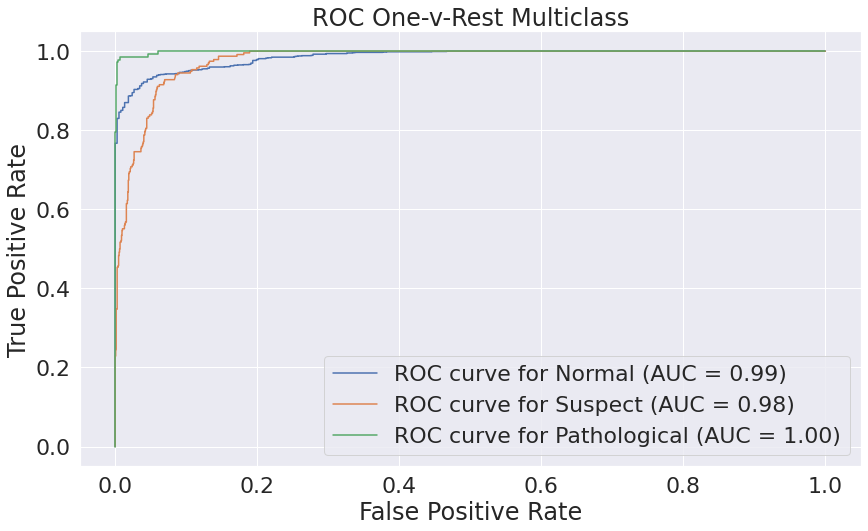

In [57]:
balanced_tree_pipeline.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(14,8))
scores_balanced_tree = model_scoring(balanced_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax, class_names=health_labels,
            average='macro')
'';

The cross val score on this model is markedly lower. We
can run a grid search on this to see if there are any
improvements that can be made.

In [58]:
balanced_tree_params = {
    'rfc__max_depth': [3,5,7,9,11],
    'rfc__min_samples_split':[2,4,6],
    'rfc__min_samples_leaf': [1,3,5],
    'rfc__min_samples_split': [2,4,6]
}
tree_weights_gs = GridSearchCV(
    balanced_tree_pipeline,
    param_grid=balanced_tree_params,
    n_jobs=-2, verbose=3)
tree_weights_gs.fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=5,
                                                               n_jobs=-2,
                                                               random_state=1))]),
             n_jobs=-2,
             param_grid={'rfc__max_depth': [3, 5, 7, 9, 11],
                         'rfc__min_samples_leaf': [1, 3, 5],
                         'rfc__min_samples_split': [2, 4, 6]},
             verbose=3)

In [59]:
tree_weights_gs.best_params_ , tree_weights_gs.best_estimator_

({'rfc__max_depth': 11,
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 4},
 Pipeline(steps=[('ss', StandardScaler()),
                 ('rfc',
                  RandomForestClassifier(class_weight='balanced', max_depth=11,
                                         min_samples_split=4, n_jobs=-2,
                                         random_state=1))]))


Model recall:       0.9943352566414232
Mean ROC AUC score: 0.9994751683429844
Cross Val Score:    0.8459650019215316
    


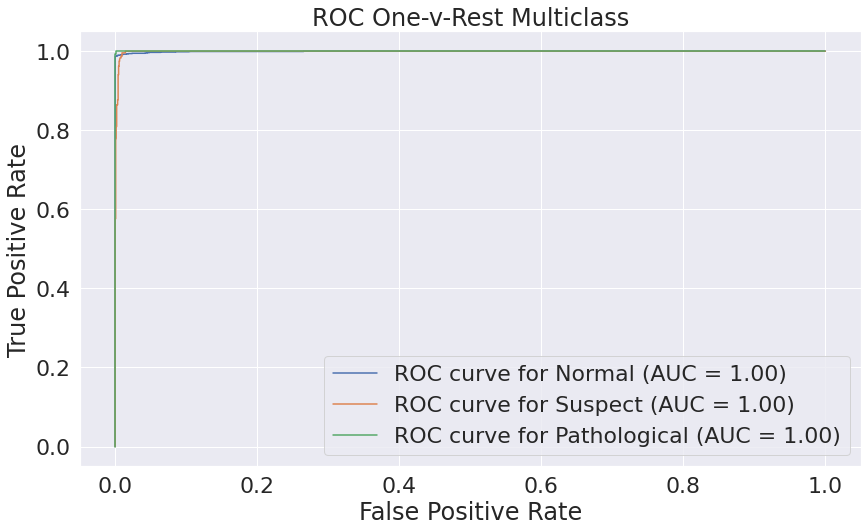

In [60]:
fig, ax = plt.subplots(figsize=(14,8))
scores_balanced_tree = model_scoring(
    tree_weights_gs.best_estimator_,
    X_train,y_train,ax=ax,average='macro',
    plot_curve=True,class_names=health_labels
)
'';

In [61]:
display(model_scoring_table([
    scores_best_knn_reduced,
    scores_best_tree_reduced,
    scores_balanced_tree
],[
    'Grid Searched Reduced KNN',
    'Grid Searched Reduced Forest',
    'Grid Searched Balanced Forest'
])['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched Reduced KNN |  0.984  | **0.999** |  0.860  |
| Grid Searched Reduced Forest |  0.960  |  0.990  | ***0.899*** |
| Grid Searched Balanced Forest | **0.994** | **0.999** |  0.846  |


It looks like this was another case of the model
pushing our cv score down and our recall up, creating
more overfit. 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


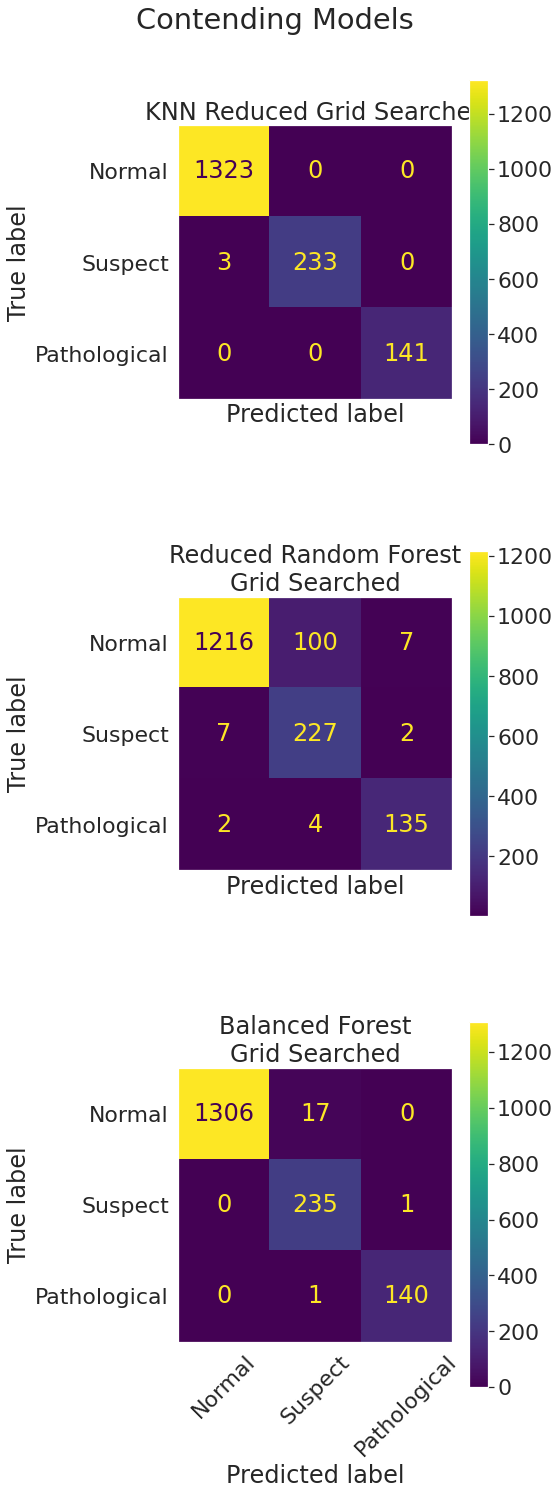

In [62]:
fig, ax = plt.subplots(3,1,figsize=(8,22),sharex=True)
ConfusionMatrixDisplay.from_estimator(
    knn_reduced_gs.fit(X_train_top_features,y_train),
    X_train_top_features,y_train,
    ax=ax[0])
ConfusionMatrixDisplay.from_estimator(
    reduced_tree_gs,
    X_train_top_features,y_train,
    ax=ax[1])
ConfusionMatrixDisplay.from_estimator(
    tree_weights_gs,X_train,y_train,
    ax=ax[2])
for ax_ in ax:
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
plt.xticks(rotation=45)

ax[0].set(
    title="KNN Reduced Grid Searched"
)
ax[1].set(
    title="Reduced Random Forest\nGrid Searched"
)
ax[2].set(
    title="Balanced Forest\nGrid Searched"
)
plt.suptitle("Contending Models")
plt.tight_layout()
'';

Currently, our grid searched forest with reduced
features model is giving us the best results with a
decent margin. We're going to go ahead and take one
more... half step in our process.

## Approach 2.5: Extra Trees

Extra Trees is a process similar to Random Forest in
that it _**is**_ a random random forest, except that it
randomly selectly features of a data set and uses those
in its predictions.

Because the Extra Trees process is extremely similar to
the Random Forest classifier with mostly the same
parameters, we're going to go ahead and run all of the
same tests in line and look at all of the results at
the end.

In [63]:
extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

balanced_extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2,
                class_weight='balanced'))
])


In [64]:
extra_tree_pipeline.fit(X_train,y_train)
balanced_extra_tree_pipeline.fit(X_train,y_train)

extra_tree_params               = {
    'o__sampling_strategy':['auto','all'],
    'etc__max_depth': [3,5,7],
    'etc__min_samples_split': [2,4,6],
    'etc__min_samples_leaf': [1,3,5],
}

extra_tree_pipeline_gs          = GridSearchCV(
    extra_tree_pipeline,
    param_grid=extra_tree_params,
    n_jobs=-2, verbose=3)

balanced_extra_tree_params      = {
    'etc__max_depth': [3,5,7,9,11],
    'etc__min_samples_split':[2,4,6],
    'etc__min_samples_leaf': [1,3,5]
}
balanced_extra_tree_pipeline_gs = GridSearchCV(
    balanced_extra_tree_pipeline,
    param_grid=balanced_extra_tree_params,
    n_jobs=-2, verbose=3)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Model recall:       0.8519804062988341
Mean ROC AUC score: 0.9699797573852486
Cross Val Score:    0.8325876480452783
    

Model recall:       0.8590726048803943
Mean ROC AUC score: 0.9719116370252658
Cross Val Score:    0.8320712364182651
    
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Model recall:       0.9029630965260248
Mean ROC AUC score: 0.9837712317443791
Cross Val Score:    0.8518125720574362
    
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 f

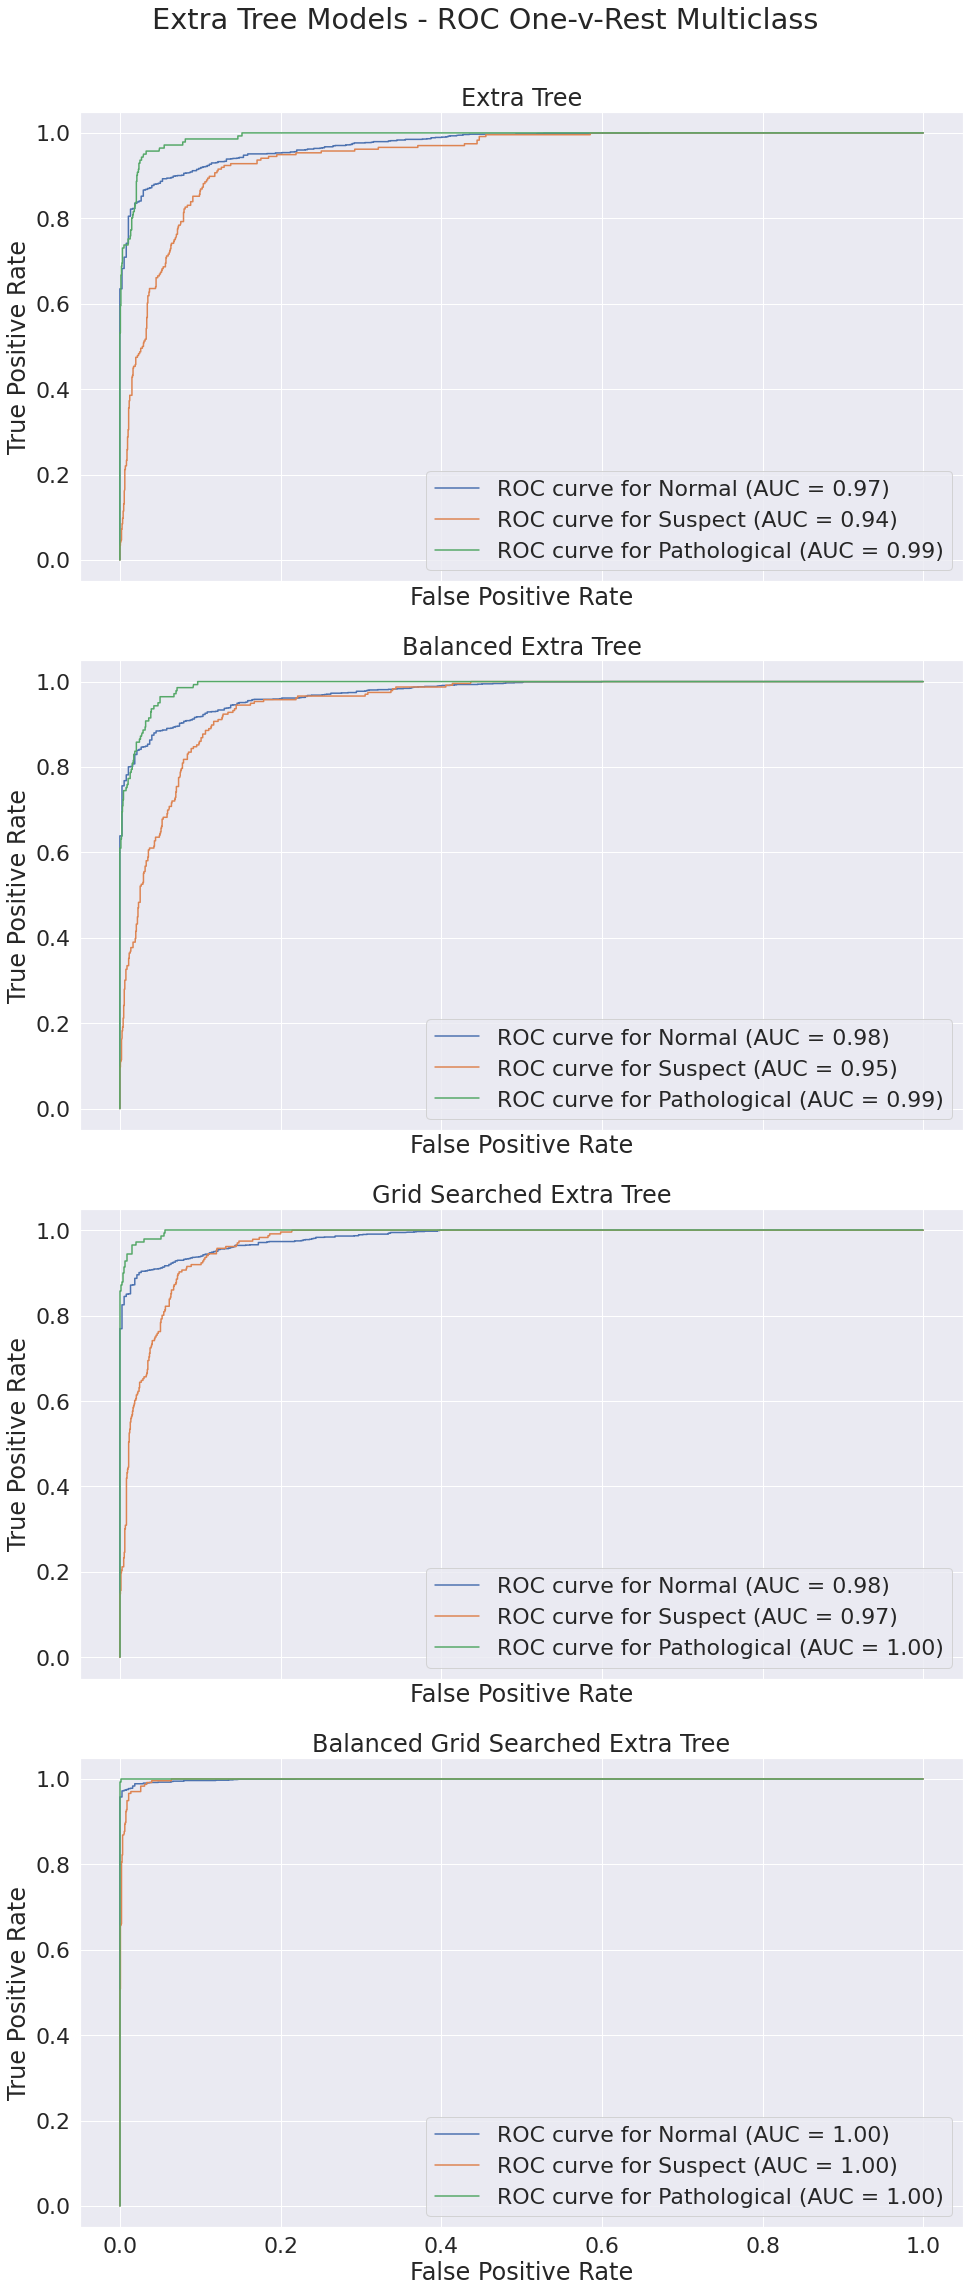

In [65]:
extra_tree_pipeline_gs.fit(X_train,y_train)
balanced_extra_tree_pipeline_gs.fit(X_train,y_train)
extra_tree_pipeline.fit(X_train,y_train)
balanced_extra_tree_pipeline.fit(X_train,y_train)

fig, ax = plt.subplots(4,1,figsize=(14,32),sharex=True)
scores_extra_tree = model_scoring(extra_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax[0], class_names=health_labels,
            average='macro')
scores_balanced_extra_tree = model_scoring(balanced_extra_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax[1], class_names=health_labels,
            average='macro')
scores_extra_tree_gs = model_scoring(extra_tree_pipeline_gs,X_train,y_train,
            plot_curve=True,ax=ax[2], class_names=health_labels,
            average='macro')
scores_balanced_extra_tree_gs = model_scoring(balanced_extra_tree_pipeline_gs,X_train,y_train,
            plot_curve=True,ax=ax[3], class_names=health_labels,
            average='macro')


ax[0].set(
    title="Extra Tree"
)
ax[1].set(
    title="Balanced Extra Tree"
)
ax[2].set(
    title="Grid Searched Extra Tree"
)
ax[3].set(
    title="Balanced Grid Searched Extra Tree"
)
fig.suptitle("Extra Tree Models - ROC One-v-Rest Multiclass",y=1)
plt.tight_layout()
'';

In [66]:
display_table = model_scoring_table([
    scores_extra_tree,
    scores_balanced_extra_tree,
    scores_extra_tree_gs,
    scores_balanced_extra_tree_gs
    ],[
        'Extra Tree',
        'Balanced Extra Tree',
        'Grid Searched Extra Tree',
        'Balanced Grid Searched Extra Tree',

    ]
)
display(display_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Extra Tree |  0.852  |  0.970  |  0.833  |
| Balanced Extra Tree |  0.859  |  0.972  |  0.832  |
| Grid Searched Extra Tree |  0.903  |  0.984  | ***0.852*** |
| Balanced Grid Searched Extra Tree | **0.994** | **0.999** |  0.832  |


It looks like our Extra Tree Classifier is giving us an
even worse CV score at this point. We're better off
sticking with the reduced random forest model from
before.

Let's go ahead and take a look at all of our best
models from each section so far to see how they
compare.

In [67]:
display_table = model_scoring_table(
    [
        scores_balanced_extra_tree_gs,
        scores_best_knn_reduced,
        scores_best_tree_reduced
    ],[
        "Balanced Grid Searched Extra Tree",
        'Grid Searched Reduced KNN',
        'GS Reduced Random Forest'
    ]
)

display(display_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Balanced Grid Searched Extra Tree | **0.994** | **0.999** |  0.832  |
| Grid Searched Reduced KNN |  0.984  | **0.999** |  0.860  |
| GS Reduced Random Forest |  0.960  |  0.990  | ***0.899*** |


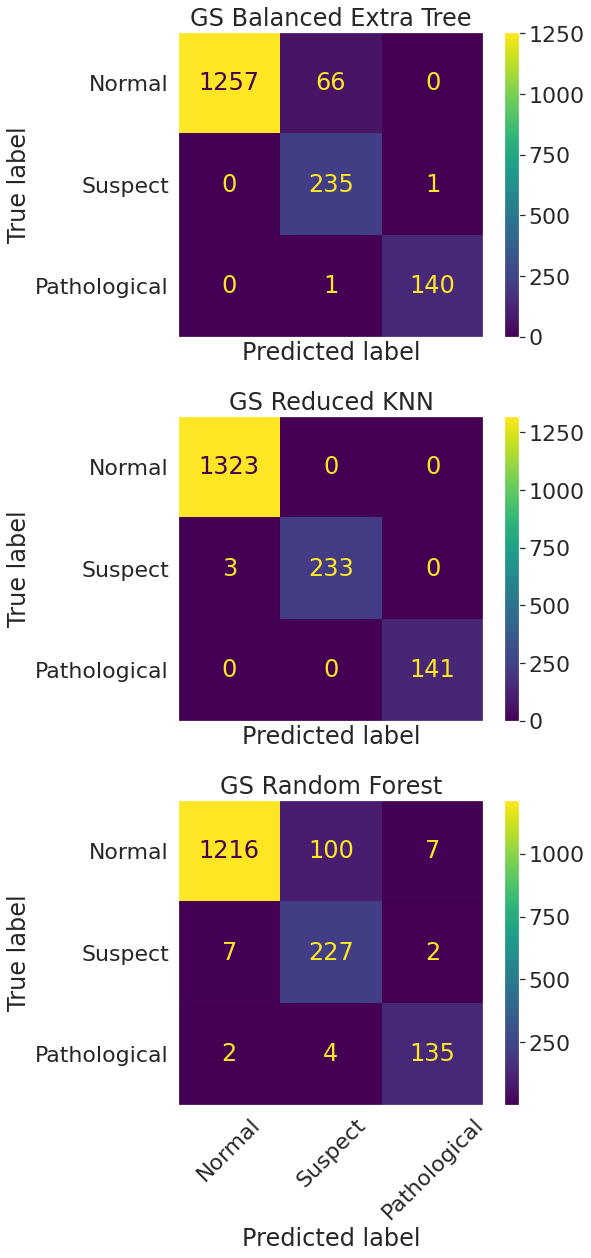

In [68]:
fig, ax = plt.subplots(3,1,figsize=(8,18),sharex=True)
ConfusionMatrixDisplay.from_estimator(
    balanced_extra_tree_pipeline_gs.best_estimator_.fit(
        X_train,y_train
        ),
    X_train,y_train,ax=ax[0]
)
ax[0].set(
    title="GS Balanced Extra Tree"
)
ConfusionMatrixDisplay.from_estimator(
    knn_reduced_gs.best_estimator_.fit(
        X_train_top_features,y_train
        ),
    X_train_top_features,y_train,ax=ax[1]
)
ax[1].set(
    title="GS Reduced KNN"
)
ConfusionMatrixDisplay.from_estimator(
    reduced_tree_gs.best_estimator_.fit(
        X_train_top_features,y_train
        ),
    X_train_top_features,y_train,ax=ax[2]
)
ax[2].set(
    title="GS Random Forest"
)

for ax_ in ax:
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
    ax_.grid(False)

plt.xticks(rotation=45)

plt.tight_layout()

Interestingly, our balanced extra tree model has our
highest recall score of the set, but our cv score is by
far the lowest of the group. This is giving us the most
overfit model by a pretty wide margin. Our goal isn't
to predict existing feature outcomes, it's to predict
new outcomes where possible. We need a model that can
generalize well to new data, which means our cross val
score is what really needs to be maxed out here.

In [69]:
# setting a preliminary final model. This will make the
# process a little bit easier later when we want to
# call back to this model later. 

nb_final_model = reduced_tree_gs.best_estimator_


For the next section, we're going to translate the data
so that any values that would indicate that something
_might_ be wrong will be counted the same as those in
which something _is_ wrong. From there, we'll run the
same types of validation and come back to our current
models for comparison.

# Option 2: Binarizing the Dataset at Large

Something I was alluding to before, the main item we're
concerned about is Healthy vs Suspect _or worse_.

Here we'll create a new set of `y_train` and `y_test`
to run our models on. Once we do this, our testing will
be mostly the same.

First, we'll verify shapes, reset target values, etc.

In [70]:
# here we set our suspect and path. values (1 and 2) to
# the same value. 
binarize = {0:0,1:1,2:1}
print(f"""Training shapes and counts:
Before:
{y_train.value_counts()}
{y_train.shape}
-----
After:
{(y_train_bin := y_train.map(binarize)).value_counts()}
{y_train_bin.shape}
========================================
Testing shape and counts:
Before:
{y_test.value_counts()}
{y_test.shape}
-----
After:
{(y_test_bin := y_test.map(binarize)).value_counts()}
{y_test_bin.shape}""")

Training shapes and counts:
Before:
0.0    1323
1.0     236
2.0     141
Name: fetal_health, dtype: int64
(1700,)
-----
After:
0    1323
1     377
Name: fetal_health, dtype: int64
(1700,)
Testing shape and counts:
Before:
0.0    332
1.0     59
2.0     35
Name: fetal_health, dtype: int64
(426,)
-----
After:
0    332
1     94
Name: fetal_health, dtype: int64
(426,)


Here, we'll go ahead and create translated versions of
all of the models from before to better fit the
binarized data.

In [71]:
binary_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])
binary_knn_pipeline.fit(X_train,y_train_bin)
reduced_binary_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])
reduced_binary_knn_pipeline.fit(X_train_top_features,y_train_bin)

binary_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
binary_tree_pipeline.fit(X_train,y_train_bin)

binary_extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
binary_extra_tree_pipeline.fit(X_train,y_train_bin)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('etc',
                 ExtraTreesClassifier(max_depth=5, n_jobs=-2, random_state=1))])

In [72]:
##! DEFINE PARAMS HERE
binary_knn_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[1,2,3]
}

binary_tree_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'rfc__max_depth': [3,5,7,9,11],
    'rfc__min_samples_split': [2,4,6]
}

binary_extra_tree_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'etc__max_depth': [3,5,7,9,11],
    'etc__min_samples_split': [2,4,6]
}

In [73]:
binary_knn_pipeline_gs = GridSearchCV(
    binary_knn_pipeline,
    param_grid=binary_knn_params,
    n_jobs=-2,verbose=3
)
reduced_binary_knn_pipeline_gs = GridSearchCV(
    reduced_binary_knn_pipeline,
    param_grid=binary_knn_params,
    n_jobs=-2,verbose=3
)
binary_tree_pipeline_gs = GridSearchCV(
    binary_tree_pipeline,
    param_grid=binary_tree_params,
    n_jobs=-2,verbose=3
)
binary_extra_tree_pipeline_gs = GridSearchCV(
    binary_extra_tree_pipeline,
    param_grid=binary_extra_tree_params,
    n_jobs=-2,verbose=3
)


In [74]:
binary_knn_pipeline_gs.fit(X_train,y_train_bin)
reduced_binary_knn_pipeline_gs.fit(X_train_top_features,y_train_bin)
binary_tree_pipeline_gs.fit(X_train,y_train_bin)
binary_extra_tree_pipeline_gs.fit(X_train,y_train_bin)
'';

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits



Model recall:       0.9787798408488063
Mean ROC AUC score: 0.9978136258924436
Cross Val Score:    0.8517192982456141
    

Model recall:       0.9628647214854111
Mean ROC AUC score: 0.9932995302453431
Cross Val Score:    0.8914035087719299
    

Model recall:       0.9787798408488063
Mean ROC AUC score: 0.9996872312143248
Cross Val Score:    0.8780701754385966
    

Model recall:       0.9787798408488063
Mean ROC AUC score: 0.9984882842025699
Cross Val Score:    0.8542105263157895
    


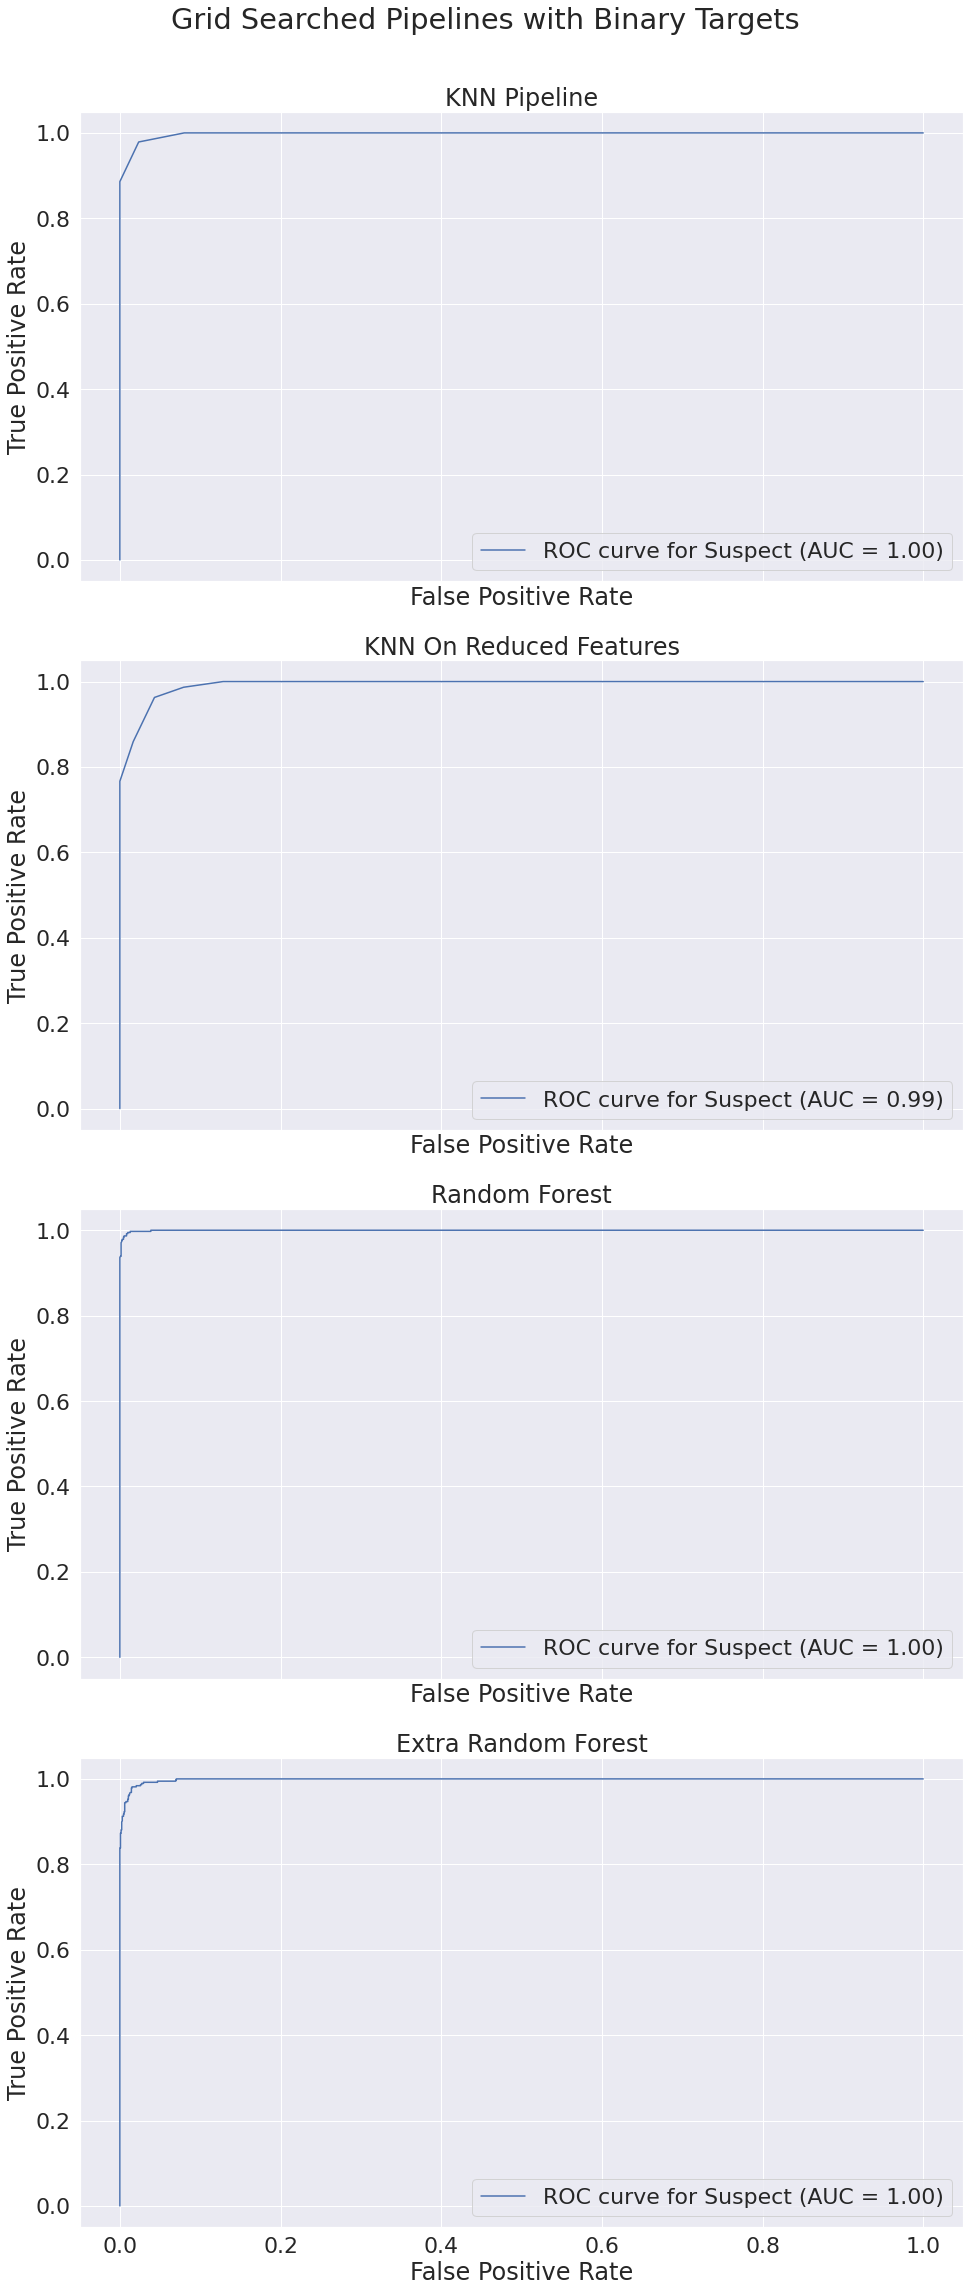

In [75]:
fig, ax = plt.subplots(4,1,figsize=(14,32),sharex=True)
scores_binary_knn_pipeline_gs = model_scoring(
            binary_knn_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[0], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_reduced_binary_knn_pipeline_gs = model_scoring(
            reduced_binary_knn_pipeline_gs.best_estimator_,
            X_train_top_features,y_train_bin,
            plot_curve=True,ax=ax[1], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_binary_tree_pipeline_gs = model_scoring(
            binary_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[2], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_binary_extra_tree_pipeline_gs = model_scoring(
            binary_extra_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[3], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)


ax[0].set(
    title="KNN Pipeline"
)
ax[1].set(
    title="KNN On Reduced Features"
)
ax[2].set(
    title="Random Forest"
)
ax[3].set(
    title="Extra Random Forest"
)
fig.suptitle("Grid Searched Pipelines with Binary Targets",y=1)
plt.tight_layout()
'';


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Binary KNN Pipeline | **0.979** |  0.998  |  0.852  |
| Binary Reduced KNN Pipeline |  0.963  |  0.993  | ***0.891*** |
| Binary Random Forest Pipeline | **0.979** | **1.000** |  0.878  |
| Binary Extra Random Forest Pipeline | **0.979** |  0.998  |  0.854  |


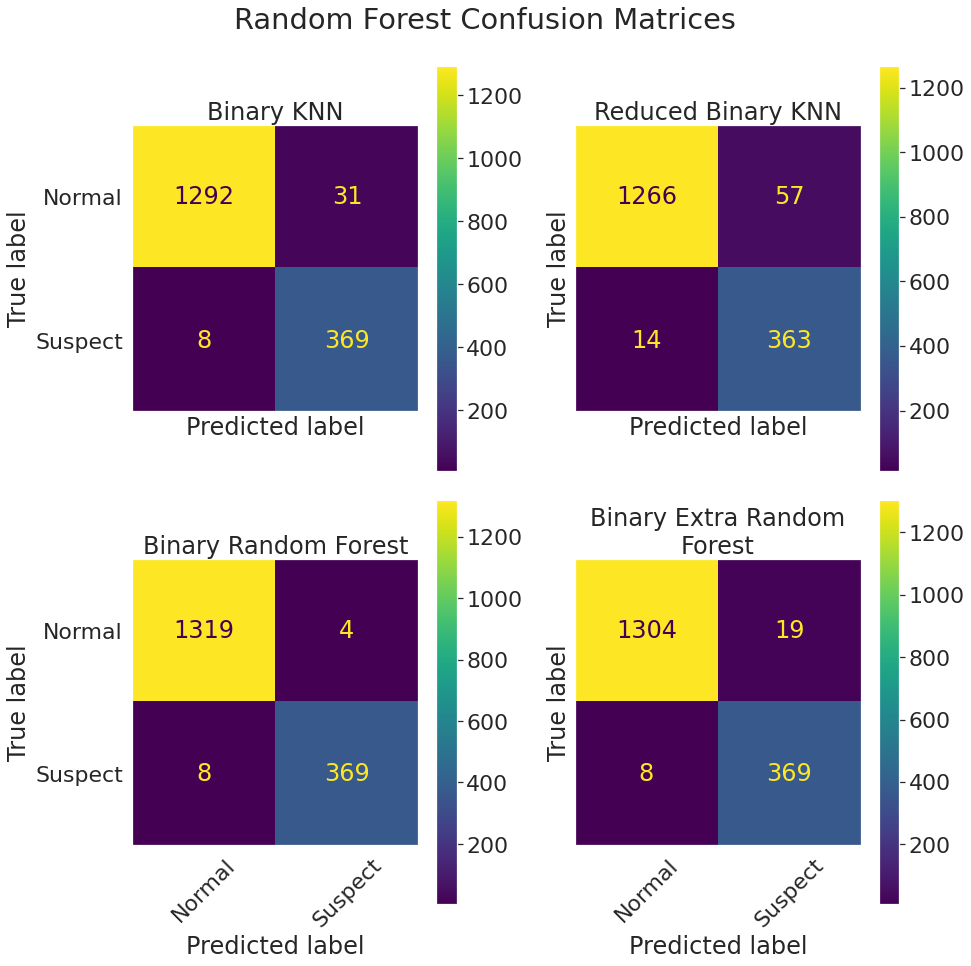

In [76]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharex=True,sharey=True)

ConfusionMatrixDisplay.from_estimator(
            binary_knn_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            reduced_binary_knn_pipeline_gs.best_estimator_,
            X_train_top_features,y_train_bin,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            binary_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            binary_extra_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,1])

ax[0,0].set(
    title='Binary KNN'
)
ax[0,1].set(
    title='Reduced Binary KNN'
)
ax[1,0].set(
    title='Binary Random Forest'
)
ax[1,1].set(
    title='Binary Extra Random\nForest'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels[:-1],
        yticklabels=health_labels[:-1]
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

fig.suptitle("Random Forest Confusion Matrices")

plt.tight_layout()

display_table = model_scoring_table([
    scores_binary_knn_pipeline_gs,
    scores_reduced_binary_knn_pipeline_gs,
    scores_binary_tree_pipeline_gs,
    scores_binary_extra_tree_pipeline_gs
    ],[
        "Binary KNN Pipeline",
        "Binary Reduced KNN Pipeline",
        "Binary Random Forest Pipeline",
        "Binary Extra Random Forest Pipeline"
    ]
)
display(display_table['md'])

In [77]:
reduced_binary_knn_pipeline_gs.best_params_ , binary_tree_pipeline_gs.best_params_

({'knn__n_neighbors': 5, 'knn__p': 1, 'o__sampling_strategy': 0.6},
 {'o__sampling_strategy': 0.6,
  'rfc__max_depth': 9,
  'rfc__min_samples_split': 4})

# The Final Model

Of our binary models, the best cross val score is in
our reduced KNN pipeline. Interestingly enough, that
model is actually generalizing worse than our original
models. At 89.1%, our KNN model in this section is
generalizing just a bit worse than our reduced random
forest from the previous section. We'll go ahead and
compare our models against each other and select our
best model overall.

In [78]:
bin_final_model = reduced_binary_knn_pipeline_gs.best_estimator_

In [79]:
bin_final_model.fit(X_train,y_train_bin)

Pipeline(steps=[('ss', StandardScaler()),
                ('o', SMOTE(random_state=1, sampling_strategy=0.6)),
                ('knn', KNeighborsClassifier(n_jobs=-2, p=1))])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Binary KNN Pipeline | **0.979** |  0.998  |  0.852  |
| Binary Reduced KNN Pipeline |  0.963  |  0.993  | ***0.891*** |
| Binary Random Forest Pipeline | **0.979** | **1.000** |  0.878  |
| Binary Extra Random Forest Pipeline | **0.979** |  0.998  |  0.854  |


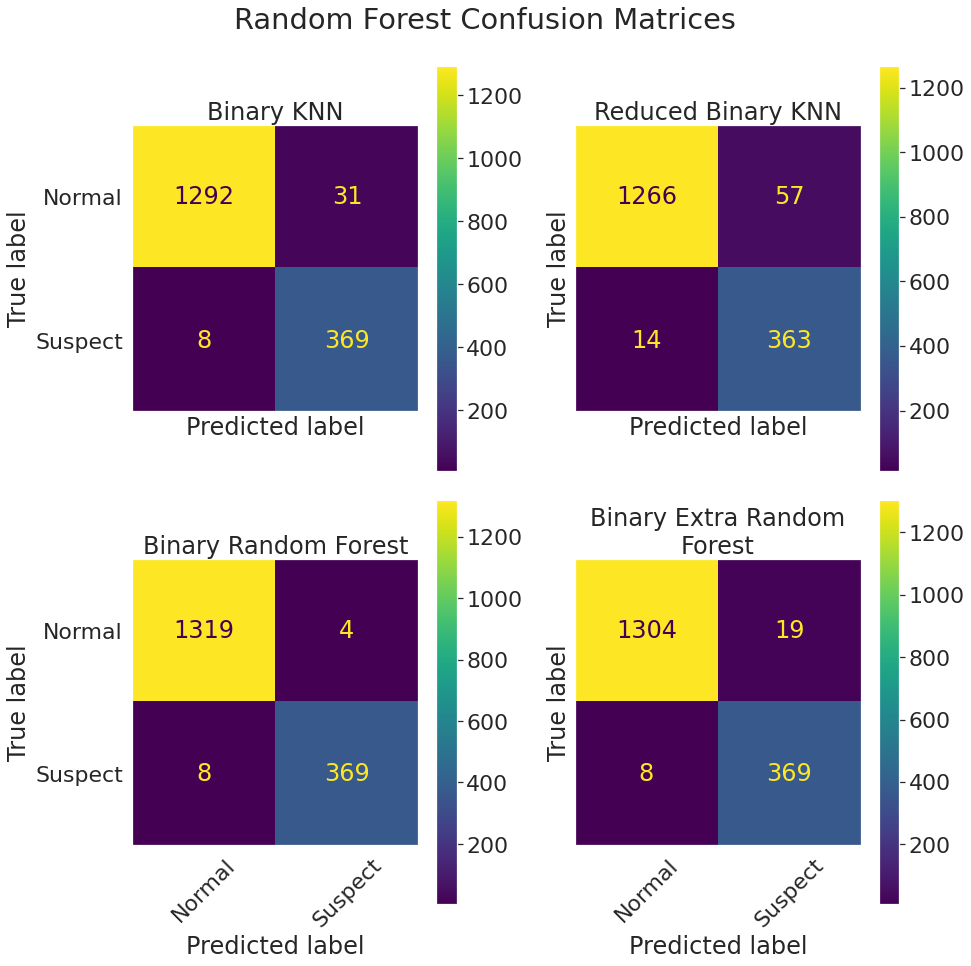

In [80]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharex=True,sharey=True)

ConfusionMatrixDisplay.from_estimator(
            binary_knn_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            reduced_binary_knn_pipeline_gs.best_estimator_.fit(X_train_top_features,y_train_bin),
            X_train_top_features,y_train_bin,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            binary_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            binary_extra_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,1])

ax[0,0].set(
    title='Binary KNN'
)
ax[0,1].set(
    title='Reduced Binary KNN'
)
ax[1,0].set(
    title='Binary Random Forest'
)
ax[1,1].set(
    title='Binary Extra Random\nForest'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels[:-1],
        yticklabels=health_labels[:-1]
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

fig.suptitle("Random Forest Confusion Matrices")

plt.tight_layout()

display_table = model_scoring_table([
    scores_binary_knn_pipeline_gs,
    scores_reduced_binary_knn_pipeline_gs,
    scores_binary_tree_pipeline_gs,
    scores_binary_extra_tree_pipeline_gs
    ],[
        "Binary KNN Pipeline",
        "Binary Reduced KNN Pipeline",
        "Binary Random Forest Pipeline",
        "Binary Extra Random Forest Pipeline"
    ]
)
display(display_table['md'])

Here, we'll make a table of ALL of the models, including
the dummy model, which has been mostly brushed off.

In [81]:
scores_dummy = model_scoring(
    dummy_baseline.fit(X_train,y_train),
    X_train, y_train,
    plot_curve=False, average='macro',
    print_scores=False
)

scores_dummy_bin = model_scoring(
    dummy_baseline.fit(X_train,y_train_bin),
    X_train, y_train_bin,
    plot_curve=False, average='macro',
    is_binary=True,
    print_scores=False
)

scores_bin_final_model = model_scoring(
    bin_final_model.fit(X_train_top_features,y_train_bin),
    X_train_top_features,y_train_bin,
    plot_curve=False,average='macro',
    is_binary=True,
    print_scores=False
)

scores_nb_final_model = model_scoring(
    nb_final_model.fit(X_train_top_features,y_train),
    X_train_top_features,y_train,
    plot_curve=False,average='macro',
    print_scores=False
)

display_table = model_scoring_table(
    [
        scores_balanced_extra_tree, scores_balanced_extra_tree_gs,
        scores_balanced_tree, scores_best_knn_initial,
        scores_best_knn_reduced, scores_best_tree_initial,
        scores_best_tree_reduced, scores_binary_extra_tree_pipeline_gs,
        scores_binary_knn_pipeline_gs, scores_binary_tree_pipeline_gs,
        scores_extra_tree, scores_extra_tree_gs,
        scores_knn_initial, scores_reduced_binary_knn_pipeline_gs,
        scores_reduced_knn_gs_weighted, scores_reduced_knn_initial,
        scores_reduced_tree_initial, scores_tree_initial,
        scores_dummy,scores_dummy_bin,
        scores_bin_final_model,scores_nb_final_model
    ],[
        'Balanced Extra Tree', 'GS Balanced Extra Tree',
        'Balanced Random Forest', 'GS Initial KNN',
        'GS Reduced KNN', 'GS Initial Forest',
        'GS Reduced Forest', 'GS Binary Extra Tree',
        'GS Binary KNN', 'GS Binary Tree',
        'Extra Tree', 'GS Extra Tree',
        'KNN Initial', 'GS Reduced Binary KNN',
        'GS Reduced KNN Weighted', 'Initial Reduced KNN',
        'Initial Reduced Tree', 'Initial Tree',
        'Dummy Model', 'Binary Dummy Model',
        'Final Binary Model','Final Non-Binary Model'
    ])
display_table['df'].sort_values('cv_mean',ascending=False,inplace=True)
display(model_scoring_table(
    display_table['df'][['recall','rocauc','cv_score']],
    list(display_table['df']['names'])
    )['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Final Non-Binary Model |  0.960  |  0.990  | ***0.899*** |
| GS Reduced Forest |  0.960  |  0.990  | ***0.899*** |
| Initial Reduced Tree |  0.935  |  0.981  |  0.895  |
| GS Initial Forest |  0.967  |  0.993  |  0.892  |
| GS Reduced Binary KNN |  0.963  |  0.993  |  0.891  |
| Final Binary Model |  0.963  |  0.993  |  0.891  |
| GS Binary Tree |  0.979  | **1.000** |  0.878  |
| Initial Reduced KNN |  0.982  |  0.997  |  0.870  |
| GS Reduced KNN |  0.984  |  0.999  |  0.860  |
| GS Reduced KNN Weighted | **0.994** | **1.000** |  0.856  |
| Initial Tree |  0.936  |  0.985  |  0.856  |
| GS Binary Extra Tree |  0.979  |  0.998  |  0.854  |
| GS Extra Tree |  0.903  |  0.984  |  0.852  |
| GS Binary KNN |  0.979  |  0.998  |  0.852  |
| KNN Initial |  0.988  |  0.998  |  0.850  |
| Balanced Random Forest | **0.994** |  0.999  |  0.846  |
| Extra Tree |  0.852  |  0.970  |  0.833  |
| Balanced Extra Tree |  0.859  |  0.972  |  0.832  |
| GS Balanced Extra Tree | **0.994** |  0.999  |  0.832  |
| GS Initial KNN |  0.992  |  0.999  |  0.823  |
| Dummy Model |  0.000  |  0.500  |  0.000  |
| Binary Dummy Model |  0.000  |  0.500  |  0.000  |


Picking out the best model of each version binary and
multiclass, so we can see this a little bit better. For
posterity, we'll compare against the dummy models to
see the improvements.

In [82]:
model_scoring_table(
    [
        scores_reduced_binary_knn_pipeline_gs,
        scores_best_tree_reduced,
        scores_dummy_bin,scores_dummy
    ],[
        'GS Binary Reduced KNN',
        'GS Reduced Forest',
        'Binary Dummy','Dummy'

    ]
)['md']


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| GS Binary Reduced KNN | **0.963** | **0.993** |  0.891  |
| GS Reduced Forest |  0.960  |  0.990  | ***0.899*** |
| Binary Dummy |  0.000  |  0.500  |  0.000  |
| Dummy |  0.000  |  0.500  |  0.000  |


We can see that our cross val score is best on the
forest with a reduced set of X values. Let's go ahead
and see how these perform on test data and get our
final results and make some observations.

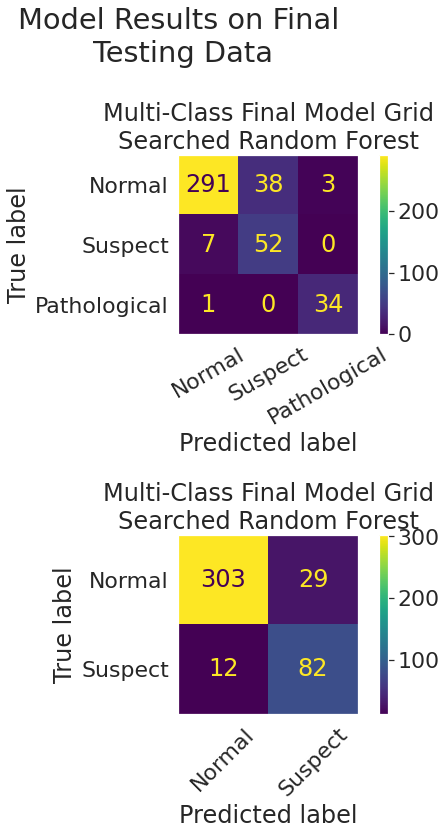

In [100]:
fig, ax = plt.subplots(2,1,figsize=(8,12))
ConfusionMatrixDisplay.from_estimator(
    nb_final_model.fit(X_train_top_features,y_train),
    X_test_top_features,y_test,
    ax=ax[0]
)
ax[0].set(
    title="Multi-Class Final Model Grid\nSearched Random Forest",
    yticklabels=health_labels,
    xticklabels=health_labels
)


ConfusionMatrixDisplay.from_estimator(
    bin_final_model.fit(X_train_top_features,y_train_bin),
    X_test_top_features,y_test_bin,
    ax=ax[1]
)
ax[1].set(
    title="Multi-Class Final Model Grid\nSearched Random Forest",
    xticklabels=health_labels[:-1],
    yticklabels=health_labels[:-1]
)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(30)

for ax_ in ax:
    ax_.grid(False)

plt.suptitle("Model Results on Final\n Testing Data")
plt.xticks(rotation=45)
plt.tight_layout()
'';


Model recall:       0.9263922518159806
Mean ROC AUC score: 0.9782291859024282
Cross Val Score:    0.7779220779220779
    



| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Final Model Against Testing Data | **0.926** | **0.978** | ***0.778*** |


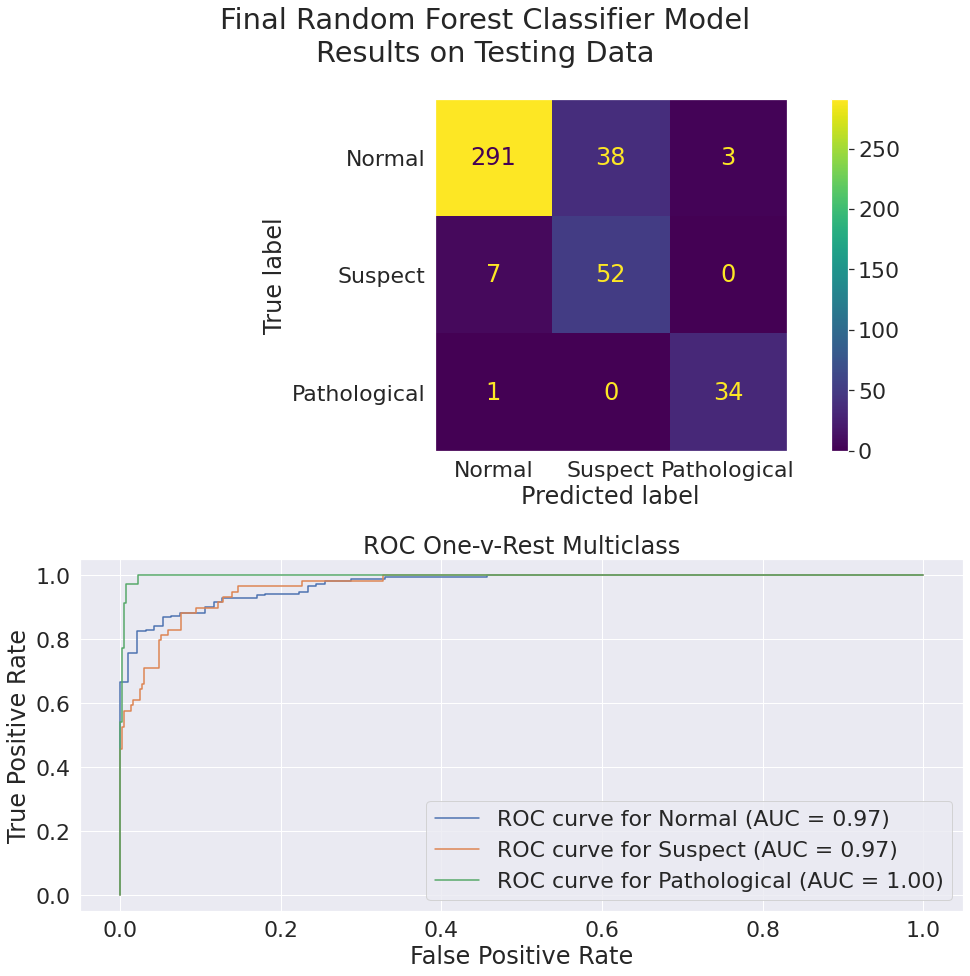

In [101]:
fig, ax = plt.subplots(2,1,figsize=(14,14))
ConfusionMatrixDisplay.from_estimator(
    nb_final_model,X_test_top_features,y_test,ax=ax[0]
)
ax[0].grid(False)

ax[0].set(
    xticklabels=health_labels,
    yticklabels=health_labels
)

testing_scores = model_scoring(
            nb_final_model,
            X_test_top_features,y_test,
            plot_curve=True,ax=ax[1], class_names=health_labels,
            average='macro',
            multi_class='ovr',
            is_binary=False)

display_table = model_scoring_table(
    [testing_scores],
    ["Final Model Against Testing Data"]
)

display(display_table['md'])

plt.suptitle("Final Random Forest Classifier Model\nResults on Testing Data")
plt.tight_layout()
'';

We can ignore our CV score in the testing data, the
sample it's using is much smaller and all we're really
concerned with in this step is the recall score. In
most cases, 92.6% is pretty good for recall, but this
is medical data that we're looking at.

# Conclusions
This process shows a lot of potential as a predictive
tool. As it stands now, it can be incredibly useful for
providing rapid insights. While the model can't predict
every case perfectly every time, it can be used as a
preliminary tool for understanding data that is fairly
complex for the average expecting parent.

The most important part of any pregnancy is safety, for
all parties involved. Every tool that can help ensure
that safety is invaluable, and this tool can be
utilized rapidly and at nearly no cost.

## Next Steps
As with any process, there is always room for
improvement. Some steps that can be taken to iterate
further on this process include the following, but are
in no way limited to them.

### A more robust data set.  
- The data set obtained for this project had just over
2000 entries. While that's enough data to train a
model, more data is always going to help in the
development of models like this.

### Investigation of additional methods.  
- There are many promising and interesting machine
learning methods available. Not all of these methods
were tried during this process, but there are several
that are still applicable that could be investigated,
such as XGBoost.

### Direct involvement of the medical community.  
- While this data was obtained from medical research,
the model training had no additional involvement from
medical personnel. I believe that an additional run
through of this more medical insight would benefit the
process greatly.


# For Comments, Information, or Inquiries...
The complete github repository is available
[here](https://github.com/ParkedHampster/Fetal-Health-Classification-Prediction),
including this notebook and all data used herein. An
abbreviated version of this laid out in
[this README file](./README.md)
or as an overview in
[this presentation](./project-overview-presentation.pdf).

I am available for contact at
[jmentz@gmx.com](mailto:jmentz@gmx.com)
for professional inquiries or otherwise.

My other projects are hosted primarily
[here, on github](https://github.com/ParkedHampster).

I maintain a semi-professional blog at
[https://parkedhampster.github.io/](https://parkedhampster.github.io/)
where I cover mostly data science topics, though with
some infrequency.

An overview of the repository structure:
```
Fetal Health Classification Project
├── code
│  ├── __init__.py
│  ├── __pycache__
│  └── model_verification.py
├── data
│  ├── fetal_health.csv
│  ├── fetal_health_descriptions.md
│  └── fetal_health_investigation.yml
├── fetal-health-research.ipynb
├── img
│  └── <Image Resources>
├── LICENSE
├── project-overview-presentation.pdf
├── README.md
└── scratch_books
   ├── code -> ../code
   ├── data -> ../data
   ├── img -> ../img
   └── scratch.ipynb
   ```

All resources used and referenced:
| Name | Purpose | Link |
|---:|:---|---|
| Fetal Health Classification | Data Set Used | https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification |
| Sisporto 2.0: A program for automated analysis of cardiotocograms | Original source research paper | https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9 |
